# Lead Scoring Case Study 

- Supervised Learning Algorithm - Logistic Regression [ Classification ]
- Programming Language - Python
- Developed by UV, VK, VY


## Initialization - Preprocessing - Visualization

### 1. Package Imports and Data Initialization

In [1]:
#   !pip install fast_ml -y    Required for constant feature identification package

from fast_ml.utilities import display_all
from fast_ml.feature_selection import get_constant_features

In [2]:
# import all libraries numpy, pandas, matplotlib, seaborn. 
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mplib
import seaborn as sns; sns.set_theme(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline

# Set custom display properties in pandas
pd.set_option("display.max_rows", 900)
pd.set_option("display.max_columns", 900) 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
# Import the necessary machine learning packages (sklearn, statsmodel) for performing logistic regression
import statsmodels.api as sm 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, recall_score,precision_score, roc_auc_score, confusion_matrix, f1_score, roc_curve, precision_recall_curve

In [4]:
# Import the dataset from leads.csv
lead_score_df = pd.read_csv('Leads.csv')
lead_score_df.head(1)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.000,0,0.000,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.000,15.000,No,No,Modified


###  ----------------------------------------------------------------------

### 2. Data Preprocesing - Part 1

#### Custom Functions for Preprocessing and EDA

In [5]:
# To distinguish numerical columns either as categorical/discrete or non categorical and return as dict
def classify_feature_dtype(df, cols):
    d_categories = {'int_cat': [], "float_ts":[] }
    for col in cols:
        if (len(df[col].unique()) < 20):
            d_categories['int_cat'].append(col)
        else:
            if not isinstance(df[col][df[col].notna()].unique()[0], str):
                d_categories['float_ts'].append(col)
            else:
                d_categories['int_cat'].append(col)
    return d_categories

# Print all statistical information for a given set of columns
def show_stats(df, cols):
    for col in list(cols):
        print("Total Nulls: {0},\nMode: {1}".format(df[col].isna().sum(), df[col].mode()[0]))
        if len(df[col].unique()) < 50:
            print("\nUnique: {0}\n".format(df[col].unique()))
        if (df[col].dtype == int) or (df[col].dtype == float):
            print("Median   : {0}, \nVariance: {1}, \n\nDescribe: {2} \n".format(df[col].median(), df[col].var(), df[col].describe()))
        print("ValueCounts: {0} \n\n\n".format((df[col].value_counts(normalize=True) * 100).head(5)))
        print("------------------------------------------------------------------")

# Return the percentage of null values in each columns in a dataframe
def check_cols_null_pct(df):
    df_non_na = df.count() / len(df)  # Ratio of non null values
    df_na_pct = (1 - df_non_na) * 100 # Find the Percentage of null values
    return df_na_pct.sort_values(ascending=False) # Sort the resulting values in descending order

# Generates charts based on the data type of the cols, as part of the univariate analysis 
# it takes dataframe, columns, train data 0,1, and feature type as args.
def univariate_plots(df, cols, target=None, ftype=None, l_dict = None):
    for col in cols:
        #generate plots and graphs for category type. (generates piechart, countplot, boxplot / if training data is provided it generates bar chart instead)
        if ftype == "categorical":
            fig, axs = plt.subplots(1, 3, figsize=(20, 6))
 
            col_idx = 0
            axs[col_idx].pie(x=df[col].value_counts().head(12), labels=df[col].value_counts().head(12).index.str[:10], autopct="%1.1f%%", 
                    radius=1, textprops={"fontsize": 10, "color": "Black"}, startangle=90, rotatelabels=False, )
            axs[col_idx].set_title("PieChart of {0}".format(col), y=1); plt.xticks(rotation=45); plt.ylabel("Percentage")
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1
            sns.countplot(data=df, y=col, order=df[col].value_counts().head(15).index, palette="viridis",  ax=axs[col_idx])
            if (l_dict is not None) and (l_dict.get(col) is not None):
                axs[col_idx].legend([ f'{k} - {v}' for k,v in l_dict[col].items()])
            axs[col_idx].set_title("Countplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col); plt.ylabel("Count")
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            col_idx += 1
            ax = sns.barplot(data=df, x=df[col].str[:10], y=target, order=df[col].value_counts().index.str[:10], palette="viridis",  ax=axs[col_idx], errwidth=0)
            for i in ax.containers:
                ax.bar_label(i,)
            axs[col_idx].set_title('Barplot against target'); plt.xticks(rotation=90); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            plt.suptitle("Univariate analysis of {0}".format(col), fontsize=12, y=0.95)
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show();
            plt.clf()

        #generate plots and graphs for numerical types. (generates boxplot, histplot, kdeplot, scatterplot)
        elif ftype == "non_categorical":        
            fig, axs = plt.subplots(1, 4, figsize=(20, 6))
            
            col_idx = 0
            
            sns.boxplot(data=df, y=col, palette="viridis", flierprops=dict(marker="o", markersize=6, markerfacecolor="red", markeredgecolor="black"),
                        medianprops=dict(linestyle="-", linewidth=3, color="#FF9900"), whiskerprops=dict(linestyle="-", linewidth=2, color="black"),
                        capprops=dict(linestyle="-", linewidth=2, color="black"), ax=axs[col_idx])
            axs[col_idx].set_title("Boxplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            axs[col_idx].hist(data=df, x=col, label=col)
            axs[col_idx].set_title("Histogram of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            sns.kdeplot(df[col], shade=True, ax=axs[col_idx])
            axs[col_idx].set_title("KDE plot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            sns.scatterplot(df[col], ax=axs[col_idx])
            axs[col_idx].set_title("Scatterplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            plt.suptitle("Univariate analysis of {0}".format(col), fontsize=12, y=0.95)
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show()
            plt.clf()

# Perform Outlier analysis on the given dataframe.
# Find Lower threshold, Upper threshold and IQR values. 
# Return the Result as a dataframe. 
# find_outlier = True argument: restricts the output df to outlier columns. whereas find_outlier = False: returns results for all columns
def get_extremeval_threshld(df, find_outlier=False):
    outlier_df = pd.DataFrame(columns=[i for i in df.columns if find_outlier == True], data=None)
    
    for col in df.columns:
        thirdq, firstq = df[col].quantile(0.75), df[col].quantile(0.25)
        iqr = 1.5 * (thirdq - firstq)
        extvalhigh, extvallow = iqr + thirdq, firstq - iqr
        
        if find_outlier == True:
            dfout = df.loc[(df[col] > extvalhigh) | (df[col] < extvallow)]
            dfout = dfout.assign(name=col, thresh_low=extvallow, thresh_high=extvalhigh)
        else:
            dfout = pd.DataFrame([[col, extvallow, extvalhigh]], columns=['name', 'thresh_low', 'thresh_high'])
            
        outlier_df = pd.concat([outlier_df, dfout])
    # outlier_df = outlier_df.reset_index(drop=True)
    outlier_df = outlier_df.set_index('name',drop=True)
    return outlier_df

#### Data Cleaning, Column Renaming, Missing Value Imputation, Feature Selection

In [6]:
#duplicates row validation by id cols
print(f"{lead_score_df.index.is_unique}, {lead_score_df.columns.is_unique}, {lead_score_df['Prospect ID'].is_unique}, {lead_score_df['Lead Number'].is_unique}")

True, True, True, True


In [7]:
# drop unnecessary columns
lead_score_df = lead_score_df.drop(columns=['Prospect ID','Lead Number', 'I agree to pay the amount through cheque', 'Last Notable Activity'])

In [8]:
# rename columns that are too long
lead_score_df = lead_score_df.rename(columns={'Total Time Spent on Website':'ttime_on_site', 'Page Views Per Visit':'pg_view_pv', 'How did you hear about X Education':'info_abt_X_Edu', 'What is your current occupation':'curr_occupation',
    'What matters most to you in choosing a course':'reason_behind_course', 'Receive More Updates About Our Courses':'more_course_updates', 'Update me on Supply Chain Content':'supply_chain_info', 'Get updates on DM Content':'get_dm',
    'Asymmetrique Activity Index':'asym_activ_idx', 'Asymmetrique Profile Index':'asym_prof_idx', 'Asymmetrique Activity Score':'asym_activ_score', 'Asymmetrique Profile Score':'asym_prof_score',
    'A free copy of Mastering The Interview':'avail_free_copy'})

In [9]:
# replace unnecessary space in columns with underscore and covert it to lower case
lead_score_df.columns = lead_score_df.columns.str.replace(pat=' ',repl='_', regex=True)
lead_score_df.columns = lead_score_df.columns.str.lower()

In [10]:
# Check the shape and size of the data frame
lead_score_df.head(1)
lead_score_df.dtypes
print(f'{lead_score_df.shape}, {lead_score_df.size}')

,lead_origin,lead_source,do_not_email,do_not_call,converted,totalvisits,ttime_on_site,pg_view_pv,last_activity,country,specialization,info_abt_x_edu,curr_occupation,reason_behind_course,search,magazine,newspaper_article,x_education_forums,newspaper,digital_advertisement,through_recommendations,more_course_updates,tags,lead_quality,supply_chain_info,get_dm,lead_profile,city,asym_activ_idx,asym_prof_idx,asym_activ_score,asym_prof_score,avail_free_copy
0,API,Olark Chat,No,No,0,0.000,0,0.000,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.000,15.000,No


lead_origin                 object
lead_source                 object
do_not_email                object
do_not_call                 object
converted                    int64
totalvisits                float64
ttime_on_site                int64
pg_view_pv                 float64
last_activity               object
country                     object
specialization              object
info_abt_x_edu              object
curr_occupation             object
reason_behind_course        object
search                      object
magazine                    object
newspaper_article           object
x_education_forums          object
newspaper                   object
digital_advertisement       object
through_recommendations     object
more_course_updates         object
tags                        object
lead_quality                object
supply_chain_info           object
get_dm                      object
lead_profile                object
city                        object
asym_activ_idx      

(9240, 33), 304920


In [11]:
# check null val percentage
# After checking the null value percentage for all the features
# We could see that there are many features that have more than 45% of non values

check_cols_null_pct(lead_score_df)

lead_quality              51.591
asym_prof_score           45.649
asym_activ_score          45.649
asym_prof_idx             45.649
asym_activ_idx            45.649
tags                      36.288
lead_profile              29.318
reason_behind_course      29.318
curr_occupation           29.113
country                   26.634
info_abt_x_edu            23.885
specialization            15.563
city                      15.368
pg_view_pv                 1.483
totalvisits                1.483
last_activity              1.115
lead_source                0.390
more_course_updates        0.000
get_dm                     0.000
supply_chain_info          0.000
lead_origin                0.000
newspaper_article          0.000
through_recommendations    0.000
digital_advertisement      0.000
newspaper                  0.000
x_education_forums         0.000
magazine                   0.000
search                     0.000
ttime_on_site              0.000
converted                  0.000
do_not_cal

In [12]:
# replace select string with nan
lead_score_df[['tags','specialization']] = lead_score_df[['tags','specialization']].replace(to_replace=['select','Select',np.nan], value='unknown') ###--------------------->>>>>>>>>>>>>>>
lead_score_df = lead_score_df.replace(to_replace=['select','Select'], value=np.nan) 

# validate select str is replaced
[i for i in lead_score_df.columns if 'select' in (lead_score_df[i].astype(str).str.lower()).str.findall('select').value_counts().index.map(''.join).to_list()]

[]

##### Constant Feature Identification

In [13]:
# check constant features that has only one values
# In the given data set there are a lot of features that have only single value as a category
# These are called as constant features and these features are of little relevance for the machine learning model hence we dropped those features

constant_features = get_constant_features(lead_score_df)
constant_features.head(10)
"','".join(constant_features['Var'].to_list())

,Desc,Var,Value,Perc
0,Constant,magazine,No,100.000
1,Constant,more_course_updates,No,100.000
2,Constant,supply_chain_info,No,100.000
3,Constant,get_dm,No,100.000
4,Quasi Constant,x_education_forums,No,99.989
5,Quasi Constant,newspaper,No,99.989
6,Quasi Constant,do_not_call,No,99.978
7,Quasi Constant,newspaper_article,No,99.978
8,Quasi Constant,digital_advertisement,No,99.957
9,Quasi Constant,through_recommendations,No,99.924


"magazine','more_course_updates','supply_chain_info','get_dm','x_education_forums','newspaper','do_not_call','newspaper_article','digital_advertisement','through_recommendations','search"

#####

In [14]:
# drop all the constant_features
lead_score_df = lead_score_df.drop(['magazine', 'more_course_updates', 'supply_chain_info', 'get_dm', 'x_education_forums', 
                                    'newspaper', 'do_not_call', 'newspaper_article', 'digital_advertisement', 'through_recommendations', 'search'], axis=1)

In [15]:
# convert dtypes
# Convert the data type of certain features from object to category type

obj_cols = lead_score_df.select_dtypes(include='object').columns
lead_score_df[obj_cols] = lead_score_df[obj_cols].astype(dtype='category')

In [16]:
# check null val percentage
# Since we have replaced select as null value for certain columns we are seeing increase in the null value percentage for those features
# Therefore we dropped all the features that have more than 40 of null values

null_pct = check_cols_null_pct(lead_score_df)
null_pct
lead_score_df = lead_score_df.drop(null_pct[null_pct > 40].index, axis=1)

info_abt_x_edu         78.463
lead_profile           74.188
lead_quality           51.591
asym_prof_score        45.649
asym_activ_score       45.649
asym_prof_idx          45.649
asym_activ_idx         45.649
city                   39.708
reason_behind_course   29.318
curr_occupation        29.113
country                26.634
totalvisits             1.483
pg_view_pv              1.483
last_activity           1.115
lead_source             0.390
lead_origin             0.000
tags                    0.000
specialization          0.000
ttime_on_site           0.000
converted               0.000
do_not_email            0.000
avail_free_copy         0.000
dtype: float64

In [17]:
null_pct = check_cols_null_pct(lead_score_df)
null_pct
na_cols = null_pct[null_pct > 0].index
na_cols

city                   39.708
reason_behind_course   29.318
curr_occupation        29.113
country                26.634
totalvisits             1.483
pg_view_pv              1.483
last_activity           1.115
lead_source             0.390
lead_origin             0.000
do_not_email            0.000
converted               0.000
ttime_on_site           0.000
specialization          0.000
tags                    0.000
avail_free_copy         0.000
dtype: float64

Index(['city', 'reason_behind_course', 'curr_occupation', 'country',
       'totalvisits', 'pg_view_pv', 'last_activity', 'lead_source'],
      dtype='object')

In [18]:
lead_score_df.describe(include=np.number)
lead_score_df.describe(exclude=np.number)

,converted,totalvisits,ttime_on_site,pg_view_pv
count,9240.000,9103.000,9240.000,9103.000
mean,0.385,3.445,487.698,2.363
std,0.487,4.855,548.021,2.161
min,0.000,0.000,0.000,0.000
25%,0.000,1.000,12.000,1.000
50%,0.000,3.000,248.000,2.000
75%,1.000,5.000,936.000,3.000
max,1.000,251.000,2272.000,55.000


,lead_origin,lead_source,do_not_email,last_activity,country,specialization,curr_occupation,reason_behind_course,tags,city,avail_free_copy
count,9240,9204,9240,9137,6779,9240,6550,6531,9240,5571,9240
unique,5,21,2,17,38,19,6,3,27,6,2
top,Landing Page Submission,Google,No,Email Opened,India,unknown,Unemployed,Better Career Prospects,unknown,Mumbai,No
freq,4886,2868,8506,3437,6492,3380,5600,6528,3353,3222,6352


In [19]:
# impute missing categorical values using mode, if a particular value in that column has higher frequency say > 50%
for i in lead_score_df.select_dtypes(include='category'):
    temp = lead_score_df[i].value_counts(normalize=True, ascending=False) * 100
    if temp.iloc[0] > 50:
        lead_score_df[i] = lead_score_df[i].fillna(temp.index[0])

In [20]:
# Now there are only two columns that have more than 36 off missing values tags and specialization

null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct > 0]

totalvisits     1.483
pg_view_pv      1.483
last_activity   1.115
lead_source     0.390
dtype: float64

In [21]:
show_stats(lead_score_df, lead_score_df.columns) ###--------------------->>>>>>>>>>>>>>>

Total Nulls: 0,
Mode: Landing Page Submission

Unique: ['API', 'Landing Page Submission', 'Lead Add Form', 'Lead Import', 'Quick Add Form']
Categories (5, object): ['API', 'Landing Page Submission', 'Lead Add Form', 'Lead Import', 'Quick Add Form']

ValueCounts: lead_origin
Landing Page Submission   52.879
API                       38.745
Lead Add Form              7.771
Lead Import                0.595
Quick Add Form             0.011
Name: proportion, dtype: float64 



------------------------------------------------------------------
Total Nulls: 36,
Mode: Google

Unique: ['Olark Chat', 'Organic Search', 'Direct Traffic', 'Google', 'Referral Sites', ..., 'welearnblog_Home', 'youtubechannel', 'testone', 'Press_Release', 'NC_EDM']
Length: 22
Categories (21, object): ['Click2call', 'Direct Traffic', 'Facebook', 'Google', ..., 'google', 'testone', 'welearnblog_Home', 'youtubechannel']

ValueCounts: lead_source
Google           31.160
Direct Traffic   27.629
Olark Chat       19.068
Orga

In [22]:
lead_score_df.dtypes

lead_origin             category
lead_source             category
do_not_email            category
converted                  int64
totalvisits              float64
ttime_on_site              int64
pg_view_pv               float64
last_activity           category
country                 category
specialization          category
curr_occupation         category
reason_behind_course    category
tags                    category
city                    category
avail_free_copy         category
dtype: object

###  ----------------------------------------------------------------------

### 3. Data Preprocesing - Part 2

#### Outlier Analysis and Capping

In [23]:
# After performing eda we identified outliers in page view per visit totalvisits ttime on site columns we therefore cap all the values to the upper cut off and lower cut off of the iqr range

ex_val_df = get_extremeval_threshld(df=lead_score_df.select_dtypes(exclude=['category','object']) )
ex_val_df
lead_score_df.describe(percentiles=[.05,.1,.2,.5,.8,.9])

,thresh_low,thresh_high
name,,
converted,-1.500,2.500
totalvisits,-5.000,11.000
ttime_on_site,-1374.000,2322.000
pg_view_pv,-2.000,6.000


,converted,totalvisits,ttime_on_site,pg_view_pv
count,9240.000,9103.000,9240.000,9103.000
mean,0.385,3.445,487.698,2.363
std,0.487,4.855,548.021,2.161
min,0.000,0.000,0.000,0.000
5%,0.000,0.000,0.000,0.000
10%,0.000,0.000,0.000,0.000
20%,0.000,0.000,0.000,0.000
50%,0.000,3.000,248.000,2.000
80%,1.000,5.000,1087.200,4.000
90%,1.000,7.000,1380.000,5.000


In [24]:
# Fix Outliers by setting either thresh low or thresh low for both extremes 
lower_cutoff = ex_val_df.loc['pg_view_pv','thresh_low']
lead_score_df['pg_view_pv'] = np.where((lead_score_df['pg_view_pv'] < lower_cutoff), lower_cutoff, lead_score_df['pg_view_pv'])
upper_cutoff = ex_val_df.loc['pg_view_pv','thresh_high']
lead_score_df['pg_view_pv'] = np.where((lead_score_df['pg_view_pv'] > upper_cutoff), upper_cutoff, lead_score_df['pg_view_pv'])

# Fix Outliers by setting either thresh low or thresh low for both extremes
lower_cutoff = ex_val_df.loc['totalvisits','thresh_low']
lead_score_df['totalvisits'] = np.where((lead_score_df['totalvisits'] < lower_cutoff), lower_cutoff, lead_score_df['totalvisits'])
upper_cutoff = ex_val_df.loc['totalvisits','thresh_high']
lead_score_df['totalvisits'] = np.where((lead_score_df['totalvisits'] > upper_cutoff), upper_cutoff, lead_score_df['totalvisits'])

# Fix Outliers by setting either thresh low or thresh low for both extremes
lower_cutoff = ex_val_df.loc['ttime_on_site','thresh_low']
lead_score_df['ttime_on_site'] = np.where((lead_score_df['ttime_on_site'] < lower_cutoff), lower_cutoff, lead_score_df['ttime_on_site'])
upper_cutoff = ex_val_df.loc['ttime_on_site','thresh_high']
lead_score_df['ttime_on_site'] = np.where((lead_score_df['ttime_on_site'] > upper_cutoff), upper_cutoff, lead_score_df['ttime_on_site'])

In [25]:
lead_score_df.describe()

,converted,totalvisits,ttime_on_site,pg_view_pv
count,9240.000,9103.000,9240.000,9103.000
mean,0.385,3.221,487.698,2.259
std,0.487,2.882,548.021,1.793
min,0.000,0.000,0.000,0.000
25%,0.000,1.000,12.000,1.000
50%,0.000,3.000,248.000,2.000
75%,1.000,5.000,936.000,3.000
max,1.000,11.000,2272.000,6.000


In [26]:
# Additionally there are few null values in their total visits and page view pub features therefore we replace with the mean of that particular column

lead_score_df['totalvisits'] = lead_score_df['totalvisits'].replace(to_replace=np.nan, value=lead_score_df['totalvisits'].median())
lead_score_df['pg_view_pv'] = lead_score_df['pg_view_pv'].replace(to_replace=np.nan, value=lead_score_df['pg_view_pv'].median())

######!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!###<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<, verify dropping of last_Activity, lead score columns>>>>>>>>>>>>>>>>>>??????????


In [27]:
# trying to remove the rows from totalvisits, pg_view_pv, last_activity and lead_source
# lead_score_df.dropna(subset=['totalvisits'], inplace=True)
# lead_score_df.dropna(subset=['pg_view_pv'], inplace=True)
lead_score_df.dropna(subset=['last_activity'], inplace=True)
lead_score_df.dropna(subset=['lead_source'], inplace=True)

In [28]:
# replace Yes, No with 1 and 0
lead_score_df = lead_score_df.replace(to_replace=['Yes', 'No'], value=[1, 0])

In [29]:
# our null values have significantly reduced
check_cols_null_pct(lead_score_df)
lead_score_df.shape

lead_origin            0.000
lead_source            0.000
do_not_email           0.000
converted              0.000
totalvisits            0.000
ttime_on_site          0.000
pg_view_pv             0.000
last_activity          0.000
country                0.000
specialization         0.000
curr_occupation        0.000
reason_behind_course   0.000
tags                   0.000
city                   0.000
avail_free_copy        0.000
dtype: float64

(9103, 15)

In [30]:
######!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!###<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<, verify dropping of last_Activity, lead score columns>>>>>>>>>>>>>>>>>>??????????

In [31]:
#lead_score_df.last_activity = lead_score_df.last_activity.fillna(lead_score_df.last_activity.mode()[0])
#lead_score_df.last_activity.value_counts(normalize=True) * 100

#lead_score_df.lead_source = lead_score_df.lead_source.fillna(lead_score_df.lead_source.mode()[0])
#lead_score_df.lead_source.value_counts(normalize=True) * 100

In [32]:
# lead_score_df.to_csv('spec_tag_analysis.csv')

lead_score_df = lead_score_df.drop(['country'], axis=1)
null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct>0] ### there are no null values

lead_score_df.shape

Series([], dtype: float64)

(9103, 14)

In [33]:
lead_score_df.dtypes

lead_origin             category
lead_source             category
do_not_email            category
converted                  int64
totalvisits              float64
ttime_on_site            float64
pg_view_pv               float64
last_activity           category
specialization          category
curr_occupation         category
reason_behind_course    category
tags                    category
city                    category
avail_free_copy         category
dtype: object

###  ----------------------------------------------------------------------

### 5. Data Imbalance & Conversion Ratio

In [34]:
# Data Imbalance
# From the target variable we have found out the imbalance ratios around 62 therefore we decide not to rebalance

imbalance_ratio = sum(lead_score_df['converted'] == 1)/sum(lead_score_df['converted'] == 0) * 100
print(f'{round(imbalance_ratio, 2)}%')

61.09%


In [35]:
# Conversion Ratio 
# From the target variable the conversion ratio is around 38 it shows that there is a very high probability of failure in conversion

converted = (sum(lead_score_df['converted'])/len(lead_score_df['converted'].index))*100
print(f'{round(converted, 2)}%')

37.92%


##  -----------------------------------------------------

In [36]:
errorline # do no remove this line

NameError: name 'errorline' is not defined

## -----------------------------------------------------

## Approach - 01

### Data Encoding

#### Dummy Encoding

In [37]:
#  we perform dummy encoding
new_ls_df = pd.get_dummies(lead_score_df, columns=lead_score_df.select_dtypes('category').columns.difference(['tags','specialization']), drop_first=True, dtype=float)
new_ls_df.head(1)
new_ls_df.shape

,converted,totalvisits,ttime_on_site,pg_view_pv,specialization,tags,avail_free_copy_1,city_Other Cities,city_Other Cities of Maharashtra,city_Other Metro Cities,city_Thane & Outskirts,city_Tier II Cities,curr_occupation_Housewife,curr_occupation_Other,curr_occupation_Student,curr_occupation_Unemployed,curr_occupation_Working Professional,do_not_email_1,last_activity_Converted to Lead,last_activity_Email Bounced,last_activity_Email Link Clicked,last_activity_Email Marked Spam,last_activity_Email Opened,last_activity_Email Received,last_activity_Form Submitted on Website,last_activity_Had a Phone Conversation,last_activity_Olark Chat Conversation,last_activity_Page Visited on Website,last_activity_Resubscribed to emails,last_activity_SMS Sent,last_activity_Unreachable,last_activity_Unsubscribed,last_activity_View in browser link Clicked,last_activity_Visited Booth in Tradeshow,lead_origin_Landing Page Submission,lead_origin_Lead Add Form,lead_origin_Lead Import,lead_origin_Quick Add Form,lead_source_Direct Traffic,lead_source_Facebook,lead_source_Google,lead_source_Live Chat,lead_source_NC_EDM,lead_source_Olark Chat,lead_source_Organic Search,lead_source_Pay per Click Ads,lead_source_Press_Release,lead_source_Reference,lead_source_Referral Sites,lead_source_Social Media,lead_source_WeLearn,lead_source_Welingak Website,lead_source_bing,lead_source_blog,lead_source_google,lead_source_testone,lead_source_welearnblog_Home,lead_source_youtubechannel,reason_behind_course_Flexibility & Convenience,reason_behind_course_Other
0,0,0.000,0.000,0.000,unknown,Interested in other courses,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


(9103, 60)

In [38]:
new_ls_df = pd.get_dummies(new_ls_df, columns=['tags','specialization'], dtype=float)
new_ls_df = new_ls_df.drop(['tags_unknown','specialization_unknown'], axis=1)
new_ls_df.shape

(9103, 102)

###  ----------------------------------------------------------------------

### Train and Test Split

In [39]:
X = new_ls_df.drop(['converted'], axis=1)
y = new_ls_df['converted']

In [40]:
# Now we split the dataset into train and test set
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

###  ----------------------------------------------------------------------

### Feature Scaling

In [43]:
new_ls_df.shape

(9103, 102)

In [41]:
new_ls_df.dtypes

converted                                                   int64
totalvisits                                               float64
ttime_on_site                                             float64
pg_view_pv                                                float64
avail_free_copy_1                                         float64
city_Other Cities                                         float64
city_Other Cities of Maharashtra                          float64
city_Other Metro Cities                                   float64
city_Thane & Outskirts                                    float64
city_Tier II Cities                                       float64
curr_occupation_Housewife                                 float64
curr_occupation_Other                                     float64
curr_occupation_Student                                   float64
curr_occupation_Unemployed                                float64
curr_occupation_Working Professional                      float64
do_not_ema

In [42]:
# Post split we perform standard scaling they fit and transform the train data set
# to_scale = ['lead_number', 'totalvisits', 'ttime_on_site', 'pg_view_pv']

to_scale = list(X.columns)
to_scale

scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale], y_train)
X_train.head(1)

['totalvisits',
 'ttime_on_site',
 'pg_view_pv',
 'avail_free_copy_1',
 'city_Other Cities',
 'city_Other Cities of Maharashtra',
 'city_Other Metro Cities',
 'city_Thane & Outskirts',
 'city_Tier II Cities',
 'curr_occupation_Housewife',
 'curr_occupation_Other',
 'curr_occupation_Student',
 'curr_occupation_Unemployed',
 'curr_occupation_Working Professional',
 'do_not_email_1',
 'last_activity_Converted to Lead',
 'last_activity_Email Bounced',
 'last_activity_Email Link Clicked',
 'last_activity_Email Marked Spam',
 'last_activity_Email Opened',
 'last_activity_Email Received',
 'last_activity_Form Submitted on Website',
 'last_activity_Had a Phone Conversation',
 'last_activity_Olark Chat Conversation',
 'last_activity_Page Visited on Website',
 'last_activity_Resubscribed to emails',
 'last_activity_SMS Sent',
 'last_activity_Unreachable',
 'last_activity_Unsubscribed',
 'last_activity_View in browser link Clicked',
 'last_activity_Visited Booth in Tradeshow',
 'lead_origin_Landi

,totalvisits,ttime_on_site,pg_view_pv,avail_free_copy_1,city_Other Cities,city_Other Cities of Maharashtra,city_Other Metro Cities,city_Thane & Outskirts,city_Tier II Cities,curr_occupation_Housewife,curr_occupation_Other,curr_occupation_Student,curr_occupation_Unemployed,curr_occupation_Working Professional,do_not_email_1,last_activity_Converted to Lead,last_activity_Email Bounced,last_activity_Email Link Clicked,last_activity_Email Marked Spam,last_activity_Email Opened,last_activity_Email Received,last_activity_Form Submitted on Website,last_activity_Had a Phone Conversation,last_activity_Olark Chat Conversation,last_activity_Page Visited on Website,last_activity_Resubscribed to emails,last_activity_SMS Sent,last_activity_Unreachable,last_activity_Unsubscribed,last_activity_View in browser link Clicked,last_activity_Visited Booth in Tradeshow,lead_origin_Landing Page Submission,lead_origin_Lead Add Form,lead_origin_Lead Import,lead_origin_Quick Add Form,lead_source_Direct Traffic,lead_source_Facebook,lead_source_Google,lead_source_Live Chat,lead_source_NC_EDM,lead_source_Olark Chat,lead_source_Organic Search,lead_source_Pay per Click Ads,lead_source_Press_Release,lead_source_Reference,lead_source_Referral Sites,lead_source_Social Media,lead_source_WeLearn,lead_source_Welingak Website,lead_source_bing,lead_source_blog,lead_source_google,lead_source_testone,lead_source_welearnblog_Home,lead_source_youtubechannel,reason_behind_course_Flexibility & Convenience,reason_behind_course_Other,tags_Already a student,tags_Busy,tags_Closed by Horizzon,tags_Diploma holder (Not Eligible),tags_Graduation in progress,tags_In confusion whether part time or DLP,tags_Interested in full time MBA,tags_Interested in Next batch,tags_Interested in other courses,tags_Lateral student,tags_Lost to EINS,tags_Lost to Others,tags_Not doing further education,tags_Recognition issue (DEC approval),tags_Ringing,tags_Shall take in the next coming month,tags_Still Thinking,tags_University not recognized,tags_Want to take admission but has financial problems,tags_Will revert after reading the email,tags_in touch with EINS,tags_invalid number,tags_number not provided,tags_opp hangup,tags_switched off,tags_wrong number given,"specialization_Banking, Investment And Insurance",specialization_Business Administration,specialization_E-Business,specialization_E-COMMERCE,specialization_Finance Management,specialization_Healthcare Management,specialization_Hospitality Management,specialization_Human Resource Management,specialization_IT Projects Management,specialization_International Business,specialization_Marketing Management,specialization_Media and Advertising,specialization_Operations Management,specialization_Retail Management,specialization_Rural and Agribusiness,specialization_Services Excellence,specialization_Supply Chain Management,specialization_Travel and Tourism
7740,-0.779,-0.376,-0.712,1.471,-0.284,4.347,-0.208,-0.293,-0.086,-0.029,-0.042,-0.152,0.335,-0.284,-0.290,4.477,-0.192,-0.176,-0.017,-0.781,-0.017,-0.122,-0.054,-0.345,-0.275,-0.012,-0.647,-0.101,-0.078,-0.029,-0.012,0.925,-0.265,-0.063,0.000,1.619,-0.064,-0.687,-0.017,-0.012,-0.485,-0.381,-0.012,-0.017,-0.231,-0.120,-0.017,-0.012,-0.119,-0.017,-0.012,-0.023,-0.012,-0.012,-0.012,-0.012,-0.012,4.372,-0.141,-0.195,-0.086,-0.114,-0.023,-0.112,-0.020,-0.245,-0.020,-0.138,-0.029,-0.127,-0.012,-0.389,-0.012,-0.023,-0.017,-0.020,-0.532,-0.035,-0.091,-0.050,-0.062,-0.164,-0.072,-0.198,-0.214,-0.079,-0.113,-0.345,-0.133,-0.111,3.113,-0.208,-0.140,-0.318,-0.150,-0.232,-0.105,-0.088,-0.063,-0.199,-0.150


###  ----------------------------------------------------------------------

### Model Building

##### Custom Functions for Model Training

In [44]:
# We create custom functions for model veiling since iteration we reuse certain functions again and again
# Train and predict function trains the model and predicts on the same data and returns the model its probability and predicted values based on cutoff
# The matrix function returns confusion matrix and accuracy score
# The vif function returns the vif score for the features

def logreg_train_pred_fn(fX_train, fy_train, fcol, fcutoff):
    fX_train_sm = sm.add_constant(fX_train[fcol])
    flogm = sm.GLM(fy_train, fX_train_sm, family = sm.families.Binomial())
    fres = flogm.fit()
    fy_train_pred = fres.predict(fX_train_sm)
    fy_train_pred = fy_train_pred.values.reshape(-1)
    fy_train_pred_final = pd.DataFrame({'Converted':fy_train.values, 'Conv_Prob':fy_train_pred})
    fy_train_pred_final['ID'] = fy_train.index
    fy_train_pred_final['predicted'] = fy_train_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_train_pred,fy_train_pred_final

def logreg_metrics_fn(fy_train_pred_final):
    fconfusion = confusion_matrix(fy_train_pred_final.Converted, fy_train_pred_final.predicted )
    faccuracy = accuracy_score(fy_train_pred_final.Converted, fy_train_pred_final.predicted)
    return fconfusion, faccuracy
   
def logreg_VIF_score_fn(fX_train, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_train[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_train[fcol].values, i) for i in range(fX_train[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

##### Base Model

In [45]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7282
Model:                            GLM   Df Residuals:                     7181
Model Family:                Binomial   Df Model:                          100
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1458.4
Date:                Sun, 20 Oct 2024   Deviance:                       2916.8
Time:                        21:17:31   Pearson chi2:                 1.01e+04
No. Iterations:                    24   Pseudo R-squ. (CS):             0.6050
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
const                                                     -1.0577    289.365     -0.004      0.997    -568.202     566.087
totalvisits                                                0.3469      0.079      4.387      0.000       0.192       0.502
ttime_on_site                                              1.0598      0.057     18.564      0.000       0.948       1.172
pg_view_pv                                                -0.3385      0.091     -3.725      0.000      -0.517      -0.160
avail_free_copy_1                                         -0.1457      0.076     -1.925      0.054      -0.294       0.003
city_Other Cities                                          0.0284      0.055      0.511      0.609      -0.080       0.137
city_Other Cities of Maharashtra                           0.0071      0.054      0.133      0.894      -0.098       0.112
city_Other Metro Cities                                    0.0141      0.054      0.261      0.794      -0.092       0.120
city_Thane & Outskirts                                    -0.0388      0.057     -0.681      0.496      -0.150       0.073
city_Tier II Cities                                        0.0424      0.051      0.826      0.409      -0.058       0.143
curr_occupation_Housewife                                  0.6591   2395.308      0.000      1.000   -4694.058    4695.376
curr_occupation_Other                                     -0.0063      0.089     -0.071      0.944      -0.180       0.167
curr_occupation_Student                                    0.0968      0.266      0.364      0.716      -0.424       0.618
curr_occupation_Unemployed                                 0.0305      0.509      0.060      0.952      -0.967       1.028
curr_occupation_Working Professional                       0.2632      0.452      0.582      0.561      -0.624       1.150
do_not_email_1                                            -0.2549      0.074     -3.453      0.001      -0.400      -0.110
last_activity_Converted to Lead                           -4.5939   1.73e+04     -0.000      1.000    -3.4e+04     3.4e+04
last_activity_Email Bounced                               -3.9668   1.51e+04     -0.000      1.000   -2.96e+04    2.96e+04
last_activity_Email Link Clicked                          -3.6148   1.39e+04     -0.000      1.000   -2.72e+04    2.72e+04
last_activity_Email Marked Spam                            0.0345   2631.053   1.31e-05      1.000   -5156.734    5156.803
last_activity_Email Opened                                -9.8780   3.95e+04     -0.000      1.000   -7.75e+04    7.75e+04
last_activity_Email Received                               0.0088   2818.345   3.12e-06      1.000   -5523.846    5523.864
last_act

##### RFE - Recursive Feature Elimination

In [46]:
# Since the data set has a lot of features we perform rfe to eliminate insignificant features
logreg = LogisticRegression()

rfe = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('totalvisits', False, 4),
 ('ttime_on_site', True, 1),
 ('pg_view_pv', False, 3),
 ('avail_free_copy_1', False, 20),
 ('city_Other Cities', False, 68),
 ('city_Other Cities of Maharashtra', False, 76),
 ('city_Other Metro Cities', False, 74),
 ('city_Thane & Outskirts', False, 58),
 ('city_Tier II Cities', False, 56),
 ('curr_occupation_Housewife', False, 21),
 ('curr_occupation_Other', False, 73),
 ('curr_occupation_Student', False, 34),
 ('curr_occupation_Unemployed', False, 67),
 ('curr_occupation_Working Professional', False, 11),
 ('do_not_email_1', False, 6),
 ('last_activity_Converted to Lead', False, 9),
 ('last_activity_Email Bounced', False, 15),
 ('last_activity_Email Link Clicked', False, 19),
 ('last_activity_Email Marked Spam', False, 32),
 ('last_activity_Email Opened', False, 72),
 ('last_activity_Email Received', False, 47),
 ('last_activity_Form Submitted on Website', False, 29),
 ('last_activity_Had a Phone Conversation', False, 26),
 ('last_activity_Olark Chat Con

In [47]:
col = X_train.columns[rfe.support_]
X_train.columns[~rfe.support_]

Index(['totalvisits', 'pg_view_pv', 'avail_free_copy_1', 'city_Other Cities',
       'city_Other Cities of Maharashtra', 'city_Other Metro Cities',
       'city_Thane & Outskirts', 'city_Tier II Cities',
       'curr_occupation_Housewife', 'curr_occupation_Other',
       'curr_occupation_Student', 'curr_occupation_Unemployed',
       'curr_occupation_Working Professional', 'do_not_email_1',
       'last_activity_Converted to Lead', 'last_activity_Email Bounced',
       'last_activity_Email Link Clicked', 'last_activity_Email Marked Spam',
       'last_activity_Email Opened', 'last_activity_Email Received',
       'last_activity_Form Submitted on Website',
       'last_activity_Had a Phone Conversation',
       'last_activity_Page Visited on Website',
       'last_activity_Resubscribed to emails', 'last_activity_Unreachable',
       'last_activity_Unsubscribed',
       'last_activity_View in browser link Clicked',
       'last_activity_Visited Booth in Tradeshow',
       'lead_origin_La

##### Model 1

In [48]:
# Now we perform model iteration as many times as possible till we get an optimum result

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')       # Accuracy Score:

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7282
Model:                            GLM   Df Residuals:                     7266
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1601.1
Date:                Sun, 20 Oct 2024   Deviance:                       3202.1
Time:                        21:17:37   Pearson chi2:                 8.54e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.5892
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -0.8841     60.489     -0.015      0.988    -119.440     117.672
ttime_on_site                                1.0554      0.052     20.110      0.000       0.953       1.158
last_activity_Olark Chat Conversation       -0.4699      0.064     -7.347      0.000      -0.595      -0.345
last_activity_SMS Sent                       0.8580      0.046     18.699      0.000       0.768       0.948
lead_origin_Lead Add Form                    0.4000      0.091      4.405      0.000       0.222       0.578
lead_source_Olark Chat                       0.5871      0.051     11.412      0.000       0.486       0.688
lead_source_Welingak Website                 0.5735      0.126      4.555      0.000       0.327       0.820
tags_Already a student                      -0.7594      0.156     -4.853      0.000      -1.066      -0.453
tags_Closed by Horizzon                      1.2012      0.136      8.801      0.000       0.934       1.469
tags_Interested in other courses            -0.4510      0.074     -6.087      0.000      -0.596      -0.306
tags_Lost to EINS                            0.6964      0.071      9.754      0.000       0.556       0.836
tags_Not doing further education            -0.3755      0.126     -2.972      0.003      -0.623      -0.128
tags_Ringing                                -0.9581      0.070    -13.702      0.000      -1.095      -0.821
tags_Will revert after reading the email     1.9035      0.069     27.620      0.000       1.768       2.039
tags_switched off                           -0.4885      0.083     -5.851      0.000      -0.652      -0.325
tags_wrong number given                     -1.6314    835.166     -0.002      0.998   -1638.527    1635.264
============================================================================================================
"""


VIF Score:


,Features,VIF
3,lead_origin_Lead Add Form,1.670
4,lead_source_Olark Chat,1.450
12,tags_Will revert after reading the email,1.450
0,ttime_on_site,1.420
5,lead_source_Welingak Website,1.310
1,last_activity_Olark Chat Conversation,1.280
7,tags_Closed by Horizzon,1.220
11,tags_Ringing,1.180
2,last_activity_SMS Sent,1.170
8,tags_Interested in other courses,1.090


##### Model 2

In [50]:
# col = col.drop('curr_occupation_Housewife', 1)
# col

#col = col.drop('tags_number not provided', 1)
#col

col = col.drop('tags_wrong number given', 1)
col
cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

Index(['ttime_on_site', 'last_activity_Olark Chat Conversation',
       'last_activity_SMS Sent', 'lead_origin_Lead Add Form',
       'lead_source_Olark Chat', 'lead_source_Welingak Website',
       'tags_Already a student', 'tags_Closed by Horizzon',
       'tags_Interested in other courses', 'tags_Lost to EINS',
       'tags_Not doing further education', 'tags_Ringing',
       'tags_Will revert after reading the email', 'tags_switched off'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7282
Model:                            GLM   Df Residuals:                     7267
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1613.0
Date:                Sun, 20 Oct 2024   Deviance:                       3225.9
Time:                        21:18:46   Pearson chi2:                 8.54e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5878
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -0.7748      0.074    -10.459      0.000      -0.920      -0.630
ttime_on_site                                1.0570      0.052     20.244      0.000       0.955       1.159
last_activity_Olark Chat Conversation       -0.4698      0.064     -7.339      0.000      -0.595      -0.344
last_activity_SMS Sent                       0.8479      0.046     18.582      0.000       0.758       0.937
lead_origin_Lead Add Form                    0.4040      0.091      4.445      0.000       0.226       0.582
lead_source_Olark Chat                       0.5964      0.051     11.614      0.000       0.496       0.697
lead_source_Welingak Website                 0.5749      0.126      4.567      0.000       0.328       0.822
tags_Already a student                      -0.7561      0.156     -4.832      0.000      -1.063      -0.449
tags_Closed by Horizzon                      1.2040      0.136      8.823      0.000       0.937       1.472
tags_Interested in other courses            -0.4463      0.074     -6.029      0.000      -0.591      -0.301
tags_Lost to EINS                            0.6987      0.071      9.785      0.000       0.559       0.839
tags_Not doing further education            -0.3729      0.126     -2.951      0.003      -0.621      -0.125
tags_Ringing                                -0.9469      0.070    -13.565      0.000      -1.084      -0.810
tags_Will revert after reading the email     1.9121      0.069     27.758      0.000       1.777       2.047
tags_switched off                           -0.4829      0.083     -5.786      0.000      -0.647      -0.319
============================================================================================================
"""


VIF Score:


,Features,VIF
3,lead_origin_Lead Add Form,1.670
4,lead_source_Olark Chat,1.450
12,tags_Will revert after reading the email,1.450
0,ttime_on_site,1.420
5,lead_source_Welingak Website,1.310
1,last_activity_Olark Chat Conversation,1.280
7,tags_Closed by Horizzon,1.220
2,last_activity_SMS Sent,1.170
11,tags_Ringing,1.170
8,tags_Interested in other courses,1.090


####  ----------------------------------------------------------------------

##### Model 3

In [ ]:
#tags_Diploma holder (Not Eligible)

col = col.drop('tags_wrong number given', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

Index(['ttime_on_site', 'last_activity_Olark Chat Conversation',
       'last_activity_SMS Sent', 'lead_origin_Landing Page Submission',
       'lead_source_Welingak Website', 'tags_Already a student',
       'tags_Closed by Horizzon', 'tags_Interested in other courses',
       'tags_Lost to EINS', 'tags_Not doing further education', 'tags_Ringing',
       'tags_Will revert after reading the email', 'tags_switched off'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7259
Model:                            GLM   Df Residuals:                     7245
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1586.1
Date:                Sun, 20 Oct 2024   Deviance:                       3172.3
Time:                        20:21:48   Pearson chi2:                 9.52e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5924
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -0.7277      0.074     -9.781      0.000      -0.874      -0.582
ttime_on_site                                0.9376      0.048     19.442      0.000       0.843       1.032
last_activity_Olark Chat Conversation       -0.4232      0.064     -6.562      0.000      -0.550      -0.297
last_activity_SMS Sent                       0.8959      0.047     19.179      0.000       0.804       0.987
lead_origin_Landing Page Submission         -0.5958      0.051    -11.661      0.000      -0.696      -0.496
lead_source_Welingak Website                 0.6037      0.091      6.636      0.000       0.425       0.782
tags_Already a student                      -0.7046      0.156     -4.505      0.000      -1.011      -0.398
tags_Closed by Horizzon                      1.2492      0.133      9.388      0.000       0.988       1.510
tags_Interested in other courses            -0.5012      0.077     -6.509      0.000      -0.652      -0.350
tags_Lost to EINS                            0.7467      0.073     10.277      0.000       0.604       0.889
tags_Not doing further education            -0.3718      0.126     -2.941      0.003      -0.620      -0.124
tags_Ringing                                -0.9074      0.068    -13.301      0.000      -1.041      -0.774
tags_Will revert after reading the email     2.0166      0.070     28.874      0.000       1.880       2.153
tags_switched off                           -0.5730      0.098     -5.867      0.000      -0.764      -0.382
============================================================================================================
"""


VIF Score:


,Features,VIF
11,tags_Will revert after reading the email,1.320
3,lead_origin_Landing Page Submission,1.250
1,last_activity_Olark Chat Conversation,1.220
0,ttime_on_site,1.210
10,tags_Ringing,1.180
2,last_activity_SMS Sent,1.170
5,tags_Already a student,1.080
7,tags_Interested in other courses,1.080
6,tags_Closed by Horizzon,1.060
4,lead_source_Welingak Website,1.050


In [51]:
X_train.shape

(7282, 101)

In [52]:
print('\nY_Predicted Values:')   # Y_Predicted Values:
y_train_pred
print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
y_train_pred_final
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')       # Accuracy Score:


Y_Predicted Values:


array([0.00229891, 0.9660518 , 0.00389388, ..., 0.56117841, 0.04373968,
       0.9930851 ])


Y_Predicted Cutoff:


,Converted,Conv_Prob,ID,predicted
0,0,0.002,7740,0
1,1,0.966,7014,1
2,0,0.004,2431,0
3,1,0.983,3012,1
4,0,0.165,3140,0
...,...,...,...,...
7277,1,0.165,4454,0
7278,0,0.020,8016,0
7279,1,0.561,4948,1
7280,0,0.044,3334,0



Confusion Matrix:


array([[4302,  204],
       [ 389, 2387]], dtype=int64)


Accuracy Score: 0.9185663279318869



In [53]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

0.8598703170028819

0.9547270306258322

#### Finding Optimal Cutoff Point

In [54]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conv_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.002,7740,0,1,0,0,0,0,0,0,0,0,0
1,1,0.966,7014,1,1,1,1,1,1,1,1,1,1,1
2,0,0.004,2431,0,1,0,0,0,0,0,0,0,0,0
3,1,0.983,3012,1,1,1,1,1,1,1,1,1,1,1
4,0,0.165,3140,0,1,1,0,0,0,0,0,0,0,0


In [55]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

       prob  accuracy  sensi  speci
0.000 0.000     0.381  1.000  0.000
0.100 0.100     0.832  0.970  0.747
0.200 0.200     0.884  0.930  0.856
0.300 0.300     0.904  0.900  0.906
0.400 0.400     0.916  0.875  0.942
0.500 0.500     0.919  0.860  0.955
0.600 0.600     0.907  0.807  0.968
0.700 0.700     0.902  0.785  0.975
0.800 0.800     0.896  0.755  0.982
0.900 0.900     0.874  0.686  0.990


<Axes: xlabel='prob'>

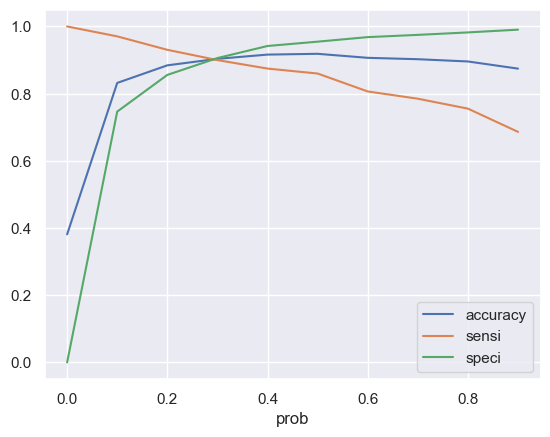

In [56]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [57]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.3 else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.002,7740,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0.966,7014,1,1,1,1,1,1,1,1,1,1,1,1
2,0,0.004,2431,0,1,0,0,0,0,0,0,0,0,0,0
3,1,0.983,3012,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0.165,3140,0,1,1,0,0,0,0,0,0,0,0,0


In [58]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.9035979126613568

In [59]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[4082,  424],
       [ 278, 2498]], dtype=int64)

In [60]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.8998559077809798

0.9059032401242787

0.9212659204940178

0.8598703170028819

####  ----------------------------------------------------------------------

#### ROC Curve and Precision - Recall Curve

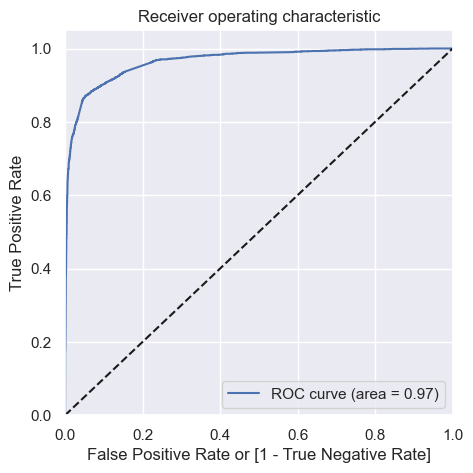

In [61]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return None

fpr, tpr, thresholds = roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conv_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)

In [62]:
precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.9212659204940178

0.8598703170028819

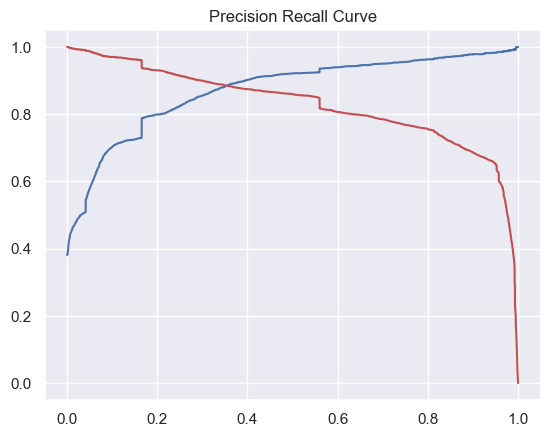

In [63]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)
plt.plot(thresholds, p[:-1], "b")
plt.plot(thresholds, r[:-1], "r")
plt.title('Precision Recall Curve')
plt.show();

In [64]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.36 else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.002,7740,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0.966,7014,1,1,1,1,1,1,1,1,1,1,1,1
2,0,0.004,2431,0,1,0,0,0,0,0,0,0,0,0,0
3,1,0.983,3012,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0.165,3140,0,1,1,0,0,0,0,0,0,0,0,0


In [65]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.9132106564130733

In [66]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[4198,  308],
       [ 324, 2452]], dtype=int64)

In [67]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.8832853025936599

0.9316466932978251

0.9212659204940178

0.8598703170028819

###  ---------------------------------------------------------------

### Predictions on the test set

##### Custom Functions for Test

In [68]:
def logreg_test_pred_fn(fX_test, fy_test, fcol, fcutoff, fres):
    fX_test_sm = sm.add_constant(fX_test[fcol])
    fy_test_pred = fres.predict(fX_test_sm)
    fy_test_pred = fy_test_pred.values.reshape(-1)
    fy_test_pred_final = pd.DataFrame({'Converted':fy_test.values, 'Conv_Prob':fy_test_pred})
    fy_test_pred_final['ID'] = fy_test.index
    fy_test_pred_final['predicted'] = fy_test_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_test_pred,fy_test_pred_final

def logreg_test_metrics_fn(fy_test_pred_final):
    fconfusion = confusion_matrix(fy_test_pred_final.Converted, fy_test_pred_final.predicted )
    faccuracy = accuracy_score(fy_test_pred_final.Converted, fy_test_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_test_VIF_score_fn(fX_test, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_test[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_test[fcol].values, i) for i in range(fX_test[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

#### Model Validation on Test Data

In [69]:
X_test[to_scale] = scaler.transform(X_test[to_scale])
X_test[col].head(2)
X_test.shape

,ttime_on_site,last_activity_Olark Chat Conversation,last_activity_SMS Sent,lead_origin_Lead Add Form,lead_source_Olark Chat,lead_source_Welingak Website,tags_Already a student,tags_Closed by Horizzon,tags_Interested in other courses,tags_Lost to EINS,tags_Not doing further education,tags_Ringing,tags_Will revert after reading the email,tags_switched off
7421,-0.502,-0.345,-0.647,-0.265,-0.485,-0.119,-0.229,5.116,-0.245,-0.138,-0.127,-0.389,-0.532,-0.164
4570,-0.409,-0.345,1.545,-0.265,-0.485,-0.119,-0.229,-0.195,-0.245,-0.138,-0.127,-0.389,-0.532,-0.164


(1821, 101)

In [70]:
cutoff = 0.39
res, y_test_pred, y_test_pred_final = logreg_test_pred_fn(X_test, y_test, col, cutoff, res)
confusion, accuracy = logreg_test_metrics_fn(y_test_pred_final)
vif = logreg_test_VIF_score_fn(X_test, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif


Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7282
Model:                            GLM   Df Residuals:                     7267
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1613.0
Date:                Sun, 20 Oct 2024   Deviance:                       3225.9
Time:                        21:26:57   Pearson chi2:                 8.54e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5878
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -0.7748      0.074    -10.459      0.000      -0.920      -0.630
ttime_on_site                                1.0570      0.052     20.244      0.000       0.955       1.159
last_activity_Olark Chat Conversation       -0.4698      0.064     -7.339      0.000      -0.595      -0.344
last_activity_SMS Sent                       0.8479      0.046     18.582      0.000       0.758       0.937
lead_origin_Lead Add Form                    0.4040      0.091      4.445      0.000       0.226       0.582
lead_source_Olark Chat                       0.5964      0.051     11.614      0.000       0.496       0.697
lead_source_Welingak Website                 0.5749      0.126      4.567      0.000       0.328       0.822
tags_Already a student                      -0.7561      0.156     -4.832      0.000      -1.063      -0.449
tags_Closed by Horizzon                      1.2040      0.136      8.823      0.000       0.937       1.472
tags_Interested in other courses            -0.4463      0.074     -6.029      0.000      -0.591      -0.301
tags_Lost to EINS                            0.6987      0.071      9.785      0.000       0.559       0.839
tags_Not doing further education            -0.3729      0.126     -2.951      0.003      -0.621      -0.125
tags_Ringing                                -0.9469      0.070    -13.565      0.000      -1.084      -0.810
tags_Will revert after reading the email     1.9121      0.069     27.758      0.000       1.777       2.047
tags_switched off                           -0.4829      0.083     -5.786      0.000      -0.647      -0.319
============================================================================================================
"""


VIF Score:


,Features,VIF
3,lead_origin_Lead Add Form,1.750
4,lead_source_Olark Chat,1.560
0,ttime_on_site,1.510
12,tags_Will revert after reading the email,1.480
1,last_activity_Olark Chat Conversation,1.350
5,lead_source_Welingak Website,1.330
7,tags_Closed by Horizzon,1.230
2,last_activity_SMS Sent,1.190
11,tags_Ringing,1.190
8,tags_Interested in other courses,1.090


In [71]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_test_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_test_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Confusion Matrix:


array([[1080,   65],
       [  61,  615]], dtype=int64)


Accuracy Score: 0.9308072487644151



In [72]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.9097633136094675

0.9432314410480349

0.9212659204940178

0.8598703170028819

## Approach - 01 - Accuracy Score:

In [73]:
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score: based on the final model.


Accuracy Score: 0.9308072487644151



## -----------------------------------------------------

In [ ]:
errorline # do no remove this line

NameError: name 'errorline' is not defined

## -----------------------------------------------------

## Approach - 02

### Data Encoding

#### Label Encoding

In [ ]:
# for label_encoding:
# Since there are many categorical features with nominal values 5 we decide to use label encoding for those features

cols_to_le = lead_score_df.select_dtypes('category').columns
cols_to_le

Index(['lead_origin', 'lead_source', 'do_not_email', 'last_activity',
       'specialization', 'curr_occupation', 'reason_behind_course', 'tags',
       'city', 'avail_free_copy'],
      dtype='object')

In [ ]:
df_le = lead_score_df.copy()

le = LabelEncoder()
df_le[cols_to_le] = lead_score_df[cols_to_le].apply(le.fit_transform)

<Figure size 1000x600 with 0 Axes>

<Axes: >

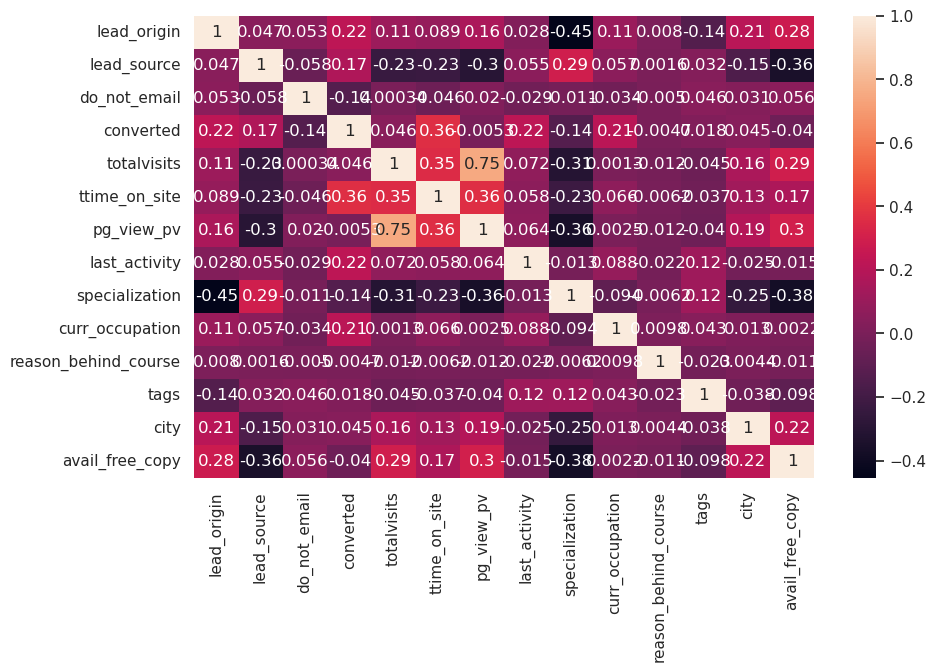

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_le.corr(), annot=True)

In [ ]:
# We then merged the encoder features with the non encoded features and name it as new lsdf

# new_ls_df = lead_score_df[lead_score_df.columns.difference(cols_to_le)]
# new_ls_df = new_ls_df.merge(right=df_le, right_index=True, left_index=True)
df_le.head(1)

,lead_origin,lead_source,do_not_email,converted,totalvisits,ttime_on_site,pg_view_pv,last_activity,specialization,curr_occupation,reason_behind_course,tags,city,avail_free_copy
0,0,6,0,0,0.000,0.000,0.000,10,18,4,0,8,0,0


In [ ]:
# our null values have significantly reduced
null_pct = check_cols_null_pct(df_le)
null_pct[null_pct>0]
df_le.shape

Series([], dtype: float64)

(9240, 14)

In [ ]:
# new_ls_df = new_ls_df[(new_ls_df.notna()).all(axis=1)]
# check_cols_null_pct(new_ls_df)
# sorted([f'{i} - {new_ls_df[i].unique()}' for i in new_ls_df.columns])

###  ----------------------------------------------------------------------

### Train and Test Split

In [ ]:
X = df_le.drop(['converted'], axis=1)
y = df_le['converted']

In [ ]:
# Now we split the dataset into train and test set
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

###  ----------------------------------------------------------------------

### Feature Scaling

In [ ]:
# Post split we perform standard scaling they fit and transform the train data set

# to_scale = ['lead_number', 'totalvisits', 'ttime_on_site', 'pg_view_pv']
to_scale = ['totalvisits', 'ttime_on_site', 'pg_view_pv', 'lead_source', 'last_activity', 'curr_occupation']

scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale],y_train)
X_train.head()

,lead_origin,lead_source,do_not_email,totalvisits,ttime_on_site,pg_view_pv,last_activity,specialization,curr_occupation,reason_behind_course,tags,city,avail_free_copy
295,0,0.918,0,0.623,-0.351,0.135,-1.276,18,-0.126,0,25,0,0
1657,0,0.589,0,-0.777,-0.498,-0.708,0.363,18,-0.126,0,25,0,0
4592,0,-0.399,0,-0.427,2.517,-0.708,1.182,1,-0.126,0,19,0,0
3558,0,0.589,0,-1.127,-0.892,-1.269,-0.730,18,-0.126,0,25,0,0
629,1,-1.057,0,0.273,-0.296,0.977,-0.730,4,-0.126,0,25,2,1


###  ----------------------------------------------------------------------

### Model Building

##### Custom Functions for Model Training

In [ ]:
# We create custom functions for model veiling since iteration we reuse certain functions again and again
# Train and predict function trains the model and predicts on the same data and returns the model its probability and predicted values based on cutoff
# The matrix function returns confusion matrix and accuracy score
# The vif function returns the vif score for the features

def logreg_train_pred_fn(fX_train, fy_train, fcol, fcutoff):
    fX_train_sm = sm.add_constant(fX_train[fcol])
    flogm = sm.GLM(fy_train, fX_train_sm, family = sm.families.Binomial())
    fres = flogm.fit()
    fy_train_pred = fres.predict(fX_train_sm)
    fy_train_pred = fy_train_pred.values.reshape(-1)
    fy_train_pred_final = pd.DataFrame({'Converted':fy_train.values, 'Conv_Prob':fy_train_pred})
    fy_train_pred_final['ID'] = fy_train.index
    fy_train_pred_final['predicted'] = fy_train_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_train_pred,fy_train_pred_final

def logreg_metrics_fn(fy_train_pred_final):
    fconfusion = confusion_matrix(fy_train_pred_final.Converted, fy_train_pred_final.predicted )
    faccuracy = accuracy_score(fy_train_pred_final.Converted, fy_train_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_VIF_score_fn(fX_train, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_train[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_train[fcol].values, i) for i in range(fX_train[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

##### Base Model 1

In [ ]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7378
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3591.9
Date:                Sun, 20 Oct 2024   Deviance:                       7183.8
Time:                        17:38:03   Pearson chi2:                 9.09e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3024
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.4760      0.119     -4.002      0.000      -0.709      -0.243
lead_origin              0.6532      0.054     12.077      0.000       0.547       0.759
lead_source              0.5352      0.035     15.348      0.000       0.467       0.604
do_not_email            -1.3020      0.137     -9.522      0.000      -1.570      -1.034
totalvisits              0.0977      0.044      2.208      0.027       0.011       0.184
ttime_on_site            1.0524      0.034     30.960      0.000       0.986       1.119
pg_view_pv              -0.4748      0.047    -10.105      0.000      -0.567      -0.383
last_activity            0.5353      0.031     17.310      0.000       0.475       0.596
specialization          -0.0472      0.006     -7.935      0.000      -0.059      -0.036
curr_occupation          0.4249      0.036     11.781      0.000       0.354       0.496
reason_behind_course    -0.3050      1.976     -0.154      0.877      -4.179       3.569
tags                     0.0103      0.004      2.691      0.007       0.003       0.018
city                     0.0083      0.023      0.356      0.722      -0.037       0.054
avail_free_copy         -0.4305      0.073     -5.918      0.000      -0.573      -0.288
========================================================================================
"""

##### RFE - Recursive Feature Elimination

In [ ]:
# Since the data set has a lot of features we perform rfe to eliminate insignificant features

logreg = LogisticRegression()

rfe = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('lead_origin', True, 1),
 ('lead_source', True, 1),
 ('do_not_email', True, 1),
 ('totalvisits', True, 1),
 ('ttime_on_site', True, 1),
 ('pg_view_pv', True, 1),
 ('last_activity', True, 1),
 ('specialization', True, 1),
 ('curr_occupation', True, 1),
 ('reason_behind_course', True, 1),
 ('tags', True, 1),
 ('city', True, 1),
 ('avail_free_copy', True, 1)]

In [ ]:
col = X_train.columns[rfe.support_]
X_train.columns[~rfe.support_]

Index([], dtype='object')

##### Model 1

In [ ]:
# Now we perform model iteration as many times as possible till we get an optimum result

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')       # Accuracy Score:

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7378
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3591.9
Date:                Sun, 20 Oct 2024   Deviance:                       7183.8
Time:                        17:38:03   Pearson chi2:                 9.09e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3024
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.4760      0.119     -4.002      0.000      -0.709      -0.243
lead_origin              0.6532      0.054     12.077      0.000       0.547       0.759
lead_source              0.5352      0.035     15.348      0.000       0.467       0.604
do_not_email            -1.3020      0.137     -9.522      0.000      -1.570      -1.034
totalvisits              0.0977      0.044      2.208      0.027       0.011       0.184
ttime_on_site            1.0524      0.034     30.960      0.000       0.986       1.119
pg_view_pv              -0.4748      0.047    -10.105      0.000      -0.567      -0.383
last_activity            0.5353      0.031     17.310      0.000       0.475       0.596
specialization          -0.0472      0.006     -7.935      0.000      -0.059      -0.036
curr_occupation          0.4249      0.036     11.781      0.000       0.354       0.496
reason_behind_course    -0.3050      1.976     -0.154      0.877      -4.179       3.569
tags                     0.0103      0.004      2.691      0.007       0.003       0.018
city                     0.0083      0.023      0.356      0.722      -0.037       0.054
avail_free_copy         -0.4305      0.073     -5.918      0.000      -0.573      -0.288
========================================================================================
"""


VIF Score:


,Features,VIF
10,tags,4.110
7,specialization,3.520
5,pg_view_pv,2.530
3,totalvisits,2.400
0,lead_origin,2.220
12,avail_free_copy,1.900
11,city,1.390
1,lead_source,1.320
4,ttime_on_site,1.210
2,do_not_email,1.110


##### Model 2

In [ ]:
# col = col.drop('avail_free_copy_1', 1)
# col

col = col.drop('tags', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

Index(['lead_origin', 'lead_source', 'do_not_email', 'totalvisits',
       'ttime_on_site', 'pg_view_pv', 'last_activity', 'specialization',
       'curr_occupation', 'reason_behind_course', 'city', 'avail_free_copy'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7379
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3595.6
Date:                Sun, 20 Oct 2024   Deviance:                       7191.1
Time:                        17:38:03   Pearson chi2:                 9.18e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3017
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2920      0.097     -3.009      0.003      -0.482      -0.102
lead_origin              0.6374      0.054     11.863      0.000       0.532       0.743
lead_source              0.5349      0.035     15.361      0.000       0.467       0.603
do_not_email            -1.2846      0.136     -9.416      0.000      -1.552      -1.017
totalvisits              0.0947      0.044      2.144      0.032       0.008       0.181
ttime_on_site            1.0508      0.034     30.944      0.000       0.984       1.117
pg_view_pv              -0.4714      0.047    -10.048      0.000      -0.563      -0.379
last_activity            0.5444      0.031     17.708      0.000       0.484       0.605
specialization          -0.0464      0.006     -7.816      0.000      -0.058      -0.035
curr_occupation          0.4263      0.036     11.865      0.000       0.356       0.497
reason_behind_course    -0.3844      1.974     -0.195      0.846      -4.253       3.484
city                     0.0090      0.023      0.386      0.700      -0.037       0.055
avail_free_copy         -0.4398      0.073     -6.057      0.000      -0.582      -0.298
========================================================================================
"""


VIF Score:


,Features,VIF
5,pg_view_pv,2.530
3,totalvisits,2.400
0,lead_origin,2.040
11,avail_free_copy,1.880
7,specialization,1.590
10,city,1.380
1,lead_source,1.310
4,ttime_on_site,1.210
2,do_not_email,1.100
8,curr_occupation,1.030


In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

##### Model 3

In [ ]:
# col = col.drop('lead_origin_Quick Add Form')
# col

# cutoff = 0.5
# res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
# confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
# vif = logreg_VIF_score_fn(X_train, col)

# print('Model Summary:')          # Model Summary:
# res.summary()
# print('\nVIF Score:')            # VIF Score:
# vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

##### Model 4

In [ ]:
# col = col.drop('lead_origin_Lead Import')
# col

# cutoff = 0.5
# res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
# confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
# vif = logreg_VIF_score_fn(X_train, col)

# print('Model Summary:')          # Model Summary:
# res.summary()
# print('\nVIF Score:')            # VIF Score:
# vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:

##### Model 5

In [ ]:
# col = col.drop('lead_origin_Lead Import')
# col

# cutoff = 0.5
# res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
# confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
# vif = logreg_VIF_score_fn(X_train, col)

# print('Model Summary:')          # Model Summary:
# res.summary()
# print('\nVIF Score:')            # VIF Score:
# vif

# # print('\nY_Predicted Values:')   # Y_Predicted Values:
# # y_train_pred
# # print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# # y_train_pred_final

# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:

##### Model 6

In [ ]:
# col = col.drop('reason_behind_course_Flexibility & Convenience')
# col

# cutoff = 0.5
# res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
# confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
# vif = logreg_VIF_score_fn(X_train, col)

# print('Model Summary:')          # Model Summary:
# res.summary()
# print('\nVIF Score:')            # VIF Score:
# vif

# # print('\nY_Predicted Values:')   # Y_Predicted Values:
# # y_train_pred
# # print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# # y_train_pred_final

# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:

####  ----------------------------------------------------------------------

#### Finding Optimal Cutoff Point

In [ ]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conv_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900
0,0,0.147,295,0,1,1,0,0,0,0,0,0,0,0
1,0,0.282,1657,0,1,1,1,0,0,0,0,0,0,0
2,1,0.951,4592,1,1,1,1,1,1,1,1,1,1,1
3,0,0.153,3558,0,1,1,0,0,0,0,0,0,0,0
4,0,0.117,629,0,1,1,0,0,0,0,0,0,0,0


In [ ]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

       prob  accuracy  sensi  speci
0.000 0.000     0.384  1.000  0.000
0.100 0.100     0.495  0.974  0.196
0.200 0.200     0.647  0.892  0.493
0.300 0.300     0.761  0.820  0.724
0.400 0.400     0.780  0.717  0.820
0.500 0.500     0.779  0.628  0.873
0.600 0.600     0.768  0.532  0.914
0.700 0.700     0.744  0.422  0.945
0.800 0.800     0.705  0.278  0.972
0.900 0.900     0.654  0.113  0.992


<Axes: xlabel='prob'>

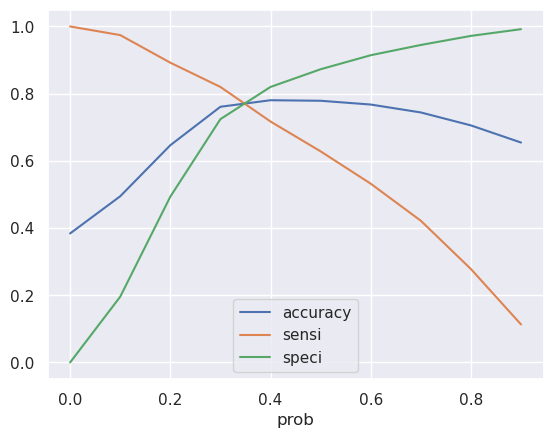

In [ ]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [ ]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.32 else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,final_predicted
0,0,0.147,295,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0.282,1657,0,1,1,1,0,0,0,0,0,0,0,0
2,1,0.951,4592,1,1,1,1,1,1,1,1,1,1,1,1
3,0,0.153,3558,0,1,1,0,0,0,0,0,0,0,0,0
4,0,0.117,629,0,1,1,0,0,0,0,0,0,0,0,0


In [ ]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.7697510822510822

In [ ]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[3397, 1157],
       [ 545, 2293]])

In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

####  ----------------------------------------------------------------------

#### ROC Curve and Precision - Recall Curve

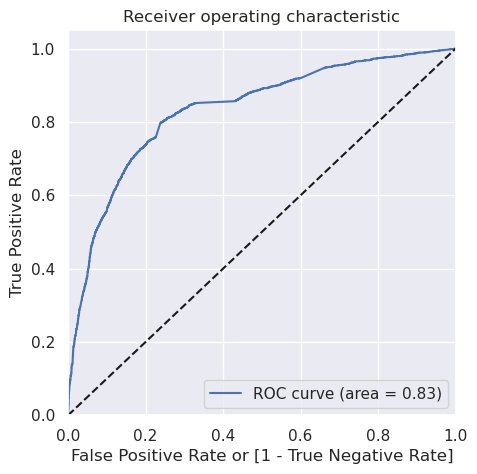

In [ ]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return None

fpr, tpr, thresholds = roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conv_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)

In [ ]:
precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.7545493017350825

0.6282593375616632

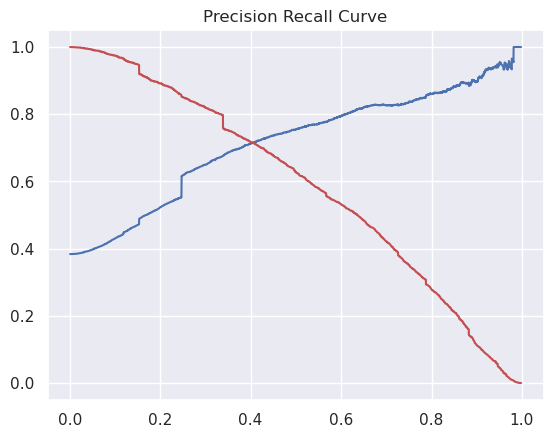

In [ ]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)
plt.plot(thresholds, p[:-1], "b")
plt.plot(thresholds, r[:-1], "r")
plt.title('Precision Recall Curve')
plt.show();

In [ ]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.39 else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,final_predicted
0,0,0.147,295,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0.282,1657,0,1,1,1,0,0,0,0,0,0,0,0
2,1,0.951,4592,1,1,1,1,1,1,1,1,1,1,1,1
3,0,0.153,3558,0,1,1,0,0,0,0,0,0,0,0,0
4,0,0.117,629,0,1,1,0,0,0,0,0,0,0,0,0


In [ ]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.7798971861471862

In [ ]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[3707,  847],
       [ 780, 2058]])

In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

###  ----------------------------------------------------------------------

### Predictions on the test set

##### Custom Functions for Test

In [ ]:
def logreg_test_pred_fn(fX_test, fy_test, fcol, fcutoff, fres):
    fX_test_sm = sm.add_constant(fX_test[fcol])
    fy_test_pred = fres.predict(fX_test_sm)
    fy_test_pred = fy_test_pred.values.reshape(-1)
    fy_test_pred_final = pd.DataFrame({'Converted':fy_test.values, 'Conv_Prob':fy_test_pred})
    fy_test_pred_final['ID'] = fy_test.index
    fy_test_pred_final['predicted'] = fy_test_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_test_pred,fy_test_pred_final

def logreg_test_metrics_fn(fy_test_pred_final):
    fconfusion = confusion_matrix(fy_test_pred_final.Converted, fy_test_pred_final.predicted )
    faccuracy = accuracy_score(fy_test_pred_final.Converted, fy_test_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_test_VIF_score_fn(fX_test, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_test[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_test[fcol].values, i) for i in range(fX_test[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

#### Model Validation on Test Data

In [ ]:
X_test[to_scale] = scaler.transform(X_test[to_scale])
X_test[col].head()

,lead_origin,lead_source,do_not_email,totalvisits,ttime_on_site,pg_view_pv,last_activity,specialization,curr_occupation,reason_behind_course,city,avail_free_copy
2212,0,-0.399,0,-0.427,1.110,-0.146,0.636,18,-0.126,0,0,0
3034,2,1.905,0,-0.777,1.380,-0.708,-1.276,18,-0.126,0,0,0
4492,0,0.589,0,-0.777,-0.531,-0.708,0.363,18,-0.126,0,0,0
5063,1,0.918,1,0.623,-0.446,0.135,1.182,7,-0.126,0,0,1
7645,0,0.589,0,-1.127,-0.892,-1.269,0.363,18,-0.126,0,0,0


In [ ]:
cutoff = 0.39
res, y_test_pred, y_test_pred_final = logreg_test_pred_fn(X_test, y_test, col, cutoff, res)
confusion, accuracy = logreg_test_metrics_fn(y_test_pred_final)
vif = logreg_test_VIF_score_fn(X_test, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_test_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_test_pred_final

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7379
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3595.6
Date:                Sun, 20 Oct 2024   Deviance:                       7191.1
Time:                        17:38:05   Pearson chi2:                 9.18e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3017
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2920      0.097     -3.009      0.003      -0.482      -0.102
lead_origin              0.6374      0.054     11.863      0.000       0.532       0.743
lead_source              0.5349      0.035     15.361      0.000       0.467       0.603
do_not_email            -1.2846      0.136     -9.416      0.000      -1.552      -1.017
totalvisits              0.0947      0.044      2.144      0.032       0.008       0.181
ttime_on_site            1.0508      0.034     30.944      0.000       0.984       1.117
pg_view_pv              -0.4714      0.047    -10.048      0.000      -0.563      -0.379
last_activity            0.5444      0.031     17.708      0.000       0.484       0.605
specialization          -0.0464      0.006     -7.816      0.000      -0.058      -0.035
curr_occupation          0.4263      0.036     11.865      0.000       0.356       0.497
reason_behind_course    -0.3844      1.974     -0.195      0.846      -4.253       3.484
city                     0.0090      0.023      0.386      0.700      -0.037       0.055
avail_free_copy         -0.4398      0.073     -6.057      0.000      -0.582      -0.298
========================================================================================
"""


VIF Score:


,Features,VIF
5,pg_view_pv,2.520
3,totalvisits,2.400
0,lead_origin,2.010
11,avail_free_copy,1.860
7,specialization,1.550
1,lead_source,1.340
10,city,1.310
4,ttime_on_site,1.230
2,do_not_email,1.100
8,curr_occupation,1.040


In [ ]:
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Confusion Matrix:


array([[923, 202],
       [201, 522]])


Accuracy Score: 0.7819264069264069



In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

## Approach - 02 - Accuracy Score:

In [ ]:
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Accuracy Score: 0.7819264069264069



## -----------------------------------------------------

In [ ]:
errorline # do no remove this line

NameError: name 'errorline' is not defined

## -----------------------------------------------------

## Approach - 03

### Data Encoding

#### Dummy Encoding

In [ ]:
#  we perform dummy encoding

new_ls_df = pd.get_dummies(lead_score_df, columns=lead_score_df.select_dtypes('category').columns.difference(['tags','specialization']), drop_first=True, dtype=float)
new_ls_df.head(1)

new_ls_df = pd.get_dummies(new_ls_df, columns=['tags','specialization'], dtype=float)
new_ls_df = new_ls_df.drop(['tags_unknown','specialization_unknown'], axis=1)
new_ls_df.head(1)

,converted,totalvisits,ttime_on_site,pg_view_pv,specialization,tags,avail_free_copy_1,city_Other Cities,city_Other Cities of Maharashtra,city_Other Metro Cities,city_Thane & Outskirts,city_Tier II Cities,curr_occupation_Housewife,curr_occupation_Other,curr_occupation_Student,curr_occupation_Unemployed,curr_occupation_Working Professional,do_not_email_1,last_activity_Converted to Lead,last_activity_Email Bounced,last_activity_Email Link Clicked,last_activity_Email Marked Spam,last_activity_Email Opened,last_activity_Email Received,last_activity_Form Submitted on Website,last_activity_Had a Phone Conversation,last_activity_Olark Chat Conversation,last_activity_Page Visited on Website,last_activity_Resubscribed to emails,last_activity_SMS Sent,last_activity_Unreachable,last_activity_Unsubscribed,last_activity_View in browser link Clicked,last_activity_Visited Booth in Tradeshow,lead_origin_Landing Page Submission,lead_origin_Lead Add Form,lead_origin_Lead Import,lead_origin_Quick Add Form,lead_source_Direct Traffic,lead_source_Facebook,lead_source_Google,lead_source_Live Chat,lead_source_NC_EDM,lead_source_Olark Chat,lead_source_Organic Search,lead_source_Pay per Click Ads,lead_source_Press_Release,lead_source_Reference,lead_source_Referral Sites,lead_source_Social Media,lead_source_WeLearn,lead_source_Welingak Website,lead_source_bing,lead_source_blog,lead_source_google,lead_source_testone,lead_source_welearnblog_Home,lead_source_youtubechannel,reason_behind_course_Flexibility & Convenience,reason_behind_course_Other
0,0,0.000,0.000,0.000,unknown,Interested in other courses,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


,converted,totalvisits,ttime_on_site,pg_view_pv,avail_free_copy_1,city_Other Cities,city_Other Cities of Maharashtra,city_Other Metro Cities,city_Thane & Outskirts,city_Tier II Cities,curr_occupation_Housewife,curr_occupation_Other,curr_occupation_Student,curr_occupation_Unemployed,curr_occupation_Working Professional,do_not_email_1,last_activity_Converted to Lead,last_activity_Email Bounced,last_activity_Email Link Clicked,last_activity_Email Marked Spam,last_activity_Email Opened,last_activity_Email Received,last_activity_Form Submitted on Website,last_activity_Had a Phone Conversation,last_activity_Olark Chat Conversation,last_activity_Page Visited on Website,last_activity_Resubscribed to emails,last_activity_SMS Sent,last_activity_Unreachable,last_activity_Unsubscribed,last_activity_View in browser link Clicked,last_activity_Visited Booth in Tradeshow,lead_origin_Landing Page Submission,lead_origin_Lead Add Form,lead_origin_Lead Import,lead_origin_Quick Add Form,lead_source_Direct Traffic,lead_source_Facebook,lead_source_Google,lead_source_Live Chat,lead_source_NC_EDM,lead_source_Olark Chat,lead_source_Organic Search,lead_source_Pay per Click Ads,lead_source_Press_Release,lead_source_Reference,lead_source_Referral Sites,lead_source_Social Media,lead_source_WeLearn,lead_source_Welingak Website,lead_source_bing,lead_source_blog,lead_source_google,lead_source_testone,lead_source_welearnblog_Home,lead_source_youtubechannel,reason_behind_course_Flexibility & Convenience,reason_behind_course_Other,tags_Already a student,tags_Busy,tags_Closed by Horizzon,tags_Diploma holder (Not Eligible),tags_Graduation in progress,tags_In confusion whether part time or DLP,tags_Interested in full time MBA,tags_Interested in Next batch,tags_Interested in other courses,tags_Lateral student,tags_Lost to EINS,tags_Lost to Others,tags_Not doing further education,tags_Recognition issue (DEC approval),tags_Ringing,tags_Shall take in the next coming month,tags_Still Thinking,tags_University not recognized,tags_Want to take admission but has financial problems,tags_Will revert after reading the email,tags_in touch with EINS,tags_invalid number,tags_number not provided,tags_opp hangup,tags_switched off,tags_wrong number given,"specialization_Banking, Investment And Insurance",specialization_Business Administration,specialization_E-Business,specialization_E-COMMERCE,specialization_Finance Management,specialization_Healthcare Management,specialization_Hospitality Management,specialization_Human Resource Management,specialization_IT Projects Management,specialization_International Business,specialization_Marketing Management,specialization_Media and Advertising,specialization_Operations Management,specialization_Retail Management,specialization_Rural and Agribusiness,specialization_Services Excellence,specialization_Supply Chain Management,specialization_Travel and Tourism
0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


###  ----------------------------------------------------------------------

### Train and Test Split

In [ ]:
X = new_ls_df.drop(['converted'], axis=1)
y = new_ls_df['converted']

In [ ]:
# Now we split the dataset into train and test set
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

###  ----------------------------------------------------------------------

### Feature Scaling

In [ ]:
new_ls_df.dtypes

converted                                                   int64
totalvisits                                               float64
ttime_on_site                                             float64
pg_view_pv                                                float64
avail_free_copy_1                                         float64
city_Other Cities                                         float64
city_Other Cities of Maharashtra                          float64
city_Other Metro Cities                                   float64
city_Thane & Outskirts                                    float64
city_Tier II Cities                                       float64
curr_occupation_Housewife                                 float64
curr_occupation_Other                                     float64
curr_occupation_Student                                   float64
curr_occupation_Unemployed                                float64
curr_occupation_Working Professional                      float64
do_not_ema

In [ ]:
# Post split we perform standard scaling they fit and transform the train data set

# to_scale = ['lead_number', 'totalvisits', 'ttime_on_site', 'pg_view_pv']
to_scale = X.columns
to_scale

scaler = MinMaxScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale], y_train)
X_train.head()

Index(['totalvisits', 'ttime_on_site', 'pg_view_pv', 'avail_free_copy_1',
       'city_Other Cities', 'city_Other Cities of Maharashtra',
       'city_Other Metro Cities', 'city_Thane & Outskirts',
       'city_Tier II Cities', 'curr_occupation_Housewife',
       ...
       'specialization_IT Projects Management',
       'specialization_International Business',
       'specialization_Marketing Management',
       'specialization_Media and Advertising',
       'specialization_Operations Management',
       'specialization_Retail Management',
       'specialization_Rural and Agribusiness',
       'specialization_Services Excellence',
       'specialization_Supply Chain Management',
       'specialization_Travel and Tourism'],
      dtype='object', length=101)

,totalvisits,ttime_on_site,pg_view_pv,avail_free_copy_1,city_Other Cities,city_Other Cities of Maharashtra,city_Other Metro Cities,city_Thane & Outskirts,city_Tier II Cities,curr_occupation_Housewife,curr_occupation_Other,curr_occupation_Student,curr_occupation_Unemployed,curr_occupation_Working Professional,do_not_email_1,last_activity_Converted to Lead,last_activity_Email Bounced,last_activity_Email Link Clicked,last_activity_Email Marked Spam,last_activity_Email Opened,last_activity_Email Received,last_activity_Form Submitted on Website,last_activity_Had a Phone Conversation,last_activity_Olark Chat Conversation,last_activity_Page Visited on Website,last_activity_Resubscribed to emails,last_activity_SMS Sent,last_activity_Unreachable,last_activity_Unsubscribed,last_activity_View in browser link Clicked,last_activity_Visited Booth in Tradeshow,lead_origin_Landing Page Submission,lead_origin_Lead Add Form,lead_origin_Lead Import,lead_origin_Quick Add Form,lead_source_Direct Traffic,lead_source_Facebook,lead_source_Google,lead_source_Live Chat,lead_source_NC_EDM,lead_source_Olark Chat,lead_source_Organic Search,lead_source_Pay per Click Ads,lead_source_Press_Release,lead_source_Reference,lead_source_Referral Sites,lead_source_Social Media,lead_source_WeLearn,lead_source_Welingak Website,lead_source_bing,lead_source_blog,lead_source_google,lead_source_testone,lead_source_welearnblog_Home,lead_source_youtubechannel,reason_behind_course_Flexibility & Convenience,reason_behind_course_Other,tags_Already a student,tags_Busy,tags_Closed by Horizzon,tags_Diploma holder (Not Eligible),tags_Graduation in progress,tags_In confusion whether part time or DLP,tags_Interested in full time MBA,tags_Interested in Next batch,tags_Interested in other courses,tags_Lateral student,tags_Lost to EINS,tags_Lost to Others,tags_Not doing further education,tags_Recognition issue (DEC approval),tags_Ringing,tags_Shall take in the next coming month,tags_Still Thinking,tags_University not recognized,tags_Want to take admission but has financial problems,tags_Will revert after reading the email,tags_in touch with EINS,tags_invalid number,tags_number not provided,tags_opp hangup,tags_switched off,tags_wrong number given,"specialization_Banking, Investment And Insurance",specialization_Business Administration,specialization_E-Business,specialization_E-COMMERCE,specialization_Finance Management,specialization_Healthcare Management,specialization_Hospitality Management,specialization_Human Resource Management,specialization_IT Projects Management,specialization_International Business,specialization_Marketing Management,specialization_Media and Advertising,specialization_Operations Management,specialization_Retail Management,specialization_Rural and Agribusiness,specialization_Services Excellence,specialization_Supply Chain Management,specialization_Travel and Tourism
295,0.455,0.131,0.417,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1657,0.091,0.095,0.167,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.

###  ----------------------------------------------------------------------

### Model Building

##### Custom Functions for Model Training

In [ ]:
# We create custom functions for model veiling since iteration we reuse certain functions again and again
# Train and predict function trains the model and predicts on the same data and returns the model its probability and predicted values based on cutoff
# The matrix function returns confusion matrix and accuracy score
# The vif function returns the vif score for the features

def logreg_train_pred_fn(fX_train, fy_train, fcol, fcutoff):
    fX_train_sm = sm.add_constant(fX_train[fcol])
    flogm = sm.GLM(fy_train, fX_train_sm, family = sm.families.Binomial())
    fres = flogm.fit()
    fy_train_pred = fres.predict(fX_train_sm)
    fy_train_pred = fy_train_pred.values.reshape(-1)
    fy_train_pred_final = pd.DataFrame({'Converted':fy_train.values, 'Conv_Prob':fy_train_pred})
    fy_train_pred_final['ID'] = fy_train.index
    fy_train_pred_final['predicted'] = fy_train_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_train_pred,fy_train_pred_final

def logreg_metrics_fn(fy_train_pred_final):
    fconfusion = confusion_matrix(fy_train_pred_final.Converted, fy_train_pred_final.predicted )
    faccuracy = accuracy_score(fy_train_pred_final.Converted, fy_train_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_VIF_score_fn(fX_train, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_train[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_train[fcol].values, i) for i in range(fX_train[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

##### Base Model 1

In [ ]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res = logm1.fit()
# res.summary()

##### RFE - Recursive Feature Elimination

In [ ]:
# Since the data set has a lot of features we perform rfe to eliminate insignificant features
logreg = LogisticRegression()

rfe = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('totalvisits', False, 11),
 ('ttime_on_site', True, 1),
 ('pg_view_pv', False, 10),
 ('avail_free_copy_1', False, 61),
 ('city_Other Cities', False, 69),
 ('city_Other Cities of Maharashtra', False, 86),
 ('city_Other Metro Cities', False, 82),
 ('city_Thane & Outskirts', False, 64),
 ('city_Tier II Cities', False, 68),
 ('curr_occupation_Housewife', False, 50),
 ('curr_occupation_Other', False, 52),
 ('curr_occupation_Student', False, 74),
 ('curr_occupation_Unemployed', False, 21),
 ('curr_occupation_Working Professional', False, 35),
 ('do_not_email_1', False, 7),
 ('last_activity_Converted to Lead', False, 6),
 ('last_activity_Email Bounced', False, 39),
 ('last_activity_Email Link Clicked', False, 55),
 ('last_activity_Email Marked Spam', False, 62),
 ('last_activity_Email Opened', False, 19),
 ('last_activity_Email Received', False, 78),
 ('last_activity_Form Submitted on Website', False, 51),
 ('last_activity_Had a Phone Conversation', False, 8),
 ('last_activity_Olark Chat Co

In [ ]:
col = X_train.columns[rfe.support_]
X_train.columns[~rfe.support_]

Index(['totalvisits', 'pg_view_pv', 'avail_free_copy_1', 'city_Other Cities',
       'city_Other Cities of Maharashtra', 'city_Other Metro Cities',
       'city_Thane & Outskirts', 'city_Tier II Cities',
       'curr_occupation_Housewife', 'curr_occupation_Other',
       'curr_occupation_Student', 'curr_occupation_Unemployed',
       'curr_occupation_Working Professional', 'do_not_email_1',
       'last_activity_Converted to Lead', 'last_activity_Email Bounced',
       'last_activity_Email Link Clicked', 'last_activity_Email Marked Spam',
       'last_activity_Email Opened', 'last_activity_Email Received',
       'last_activity_Form Submitted on Website',
       'last_activity_Had a Phone Conversation',
       'last_activity_Olark Chat Conversation',
       'last_activity_Page Visited on Website',
       'last_activity_Resubscribed to emails', 'last_activity_Unreachable',
       'last_activity_Unsubscribed',
       'last_activity_View in browser link Clicked',
       'last_activity_Vis

##### Model 1

In [ ]:
# Now we perform model iteration as many times as possible till we get an optimum result

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')       # Accuracy Score:

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7376
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1662.6
Date:                Sun, 20 Oct 2024   Deviance:                       3325.1
Time:                        17:48:20   Pearson chi2:                 8.01e+03
No. Iterations:                    23   Pseudo R-squ. (CS):             0.5861
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -2.6163      0.080    -32.533      0.000      -2.774      -2.459
ttime_on_site                                3.3315      0.187     17.783      0.000       2.964       3.699
last_activity_SMS Sent                       1.9934      0.096     20.678      0.000       1.804       2.182
lead_source_Welingak Website                 5.3886      0.727      7.413      0.000       3.964       6.813
tags_Already a student                      -3.5340      0.714     -4.951      0.000      -4.933      -2.135
tags_Closed by Horizzon                      6.7310      0.715      9.415      0.000       5.330       8.132
tags_Interested  in full time MBA           -2.4360      0.749     -3.253      0.001      -3.904      -0.968
tags_Interested in other courses            -1.9668      0.313     -6.289      0.000      -2.580      -1.354
tags_Lost to EINS                            5.0718      0.518      9.798      0.000       4.057       6.086
tags_Not doing further education            -3.3423      1.013     -3.300      0.001      -5.328      -1.357
tags_Ringing                                -2.8643      0.207    -13.819      0.000      -3.271      -2.458
tags_Will revert after reading the email     4.5023      0.150     29.964      0.000       4.208       4.797
tags_invalid number                         -3.4765      1.065     -3.264      0.001      -5.564      -1.389
tags_number not provided                   -24.0707   2.43e+04     -0.001      0.999   -4.77e+04    4.76e+04
tags_switched off                           -3.3473      0.520     -6.434      0.000      -4.367      -2.328
tags_wrong number given                    -23.8164   1.93e+04     -0.001      0.999   -3.79e+04    3.79e+04
============================================================================================================
"""


VIF Score:


,Features,VIF
0,ttime_on_site,1.680
10,tags_Will revert after reading the email,1.550
1,last_activity_SMS Sent,1.480
9,tags_Ringing,1.110
4,tags_Closed by Horizzon,1.060
7,tags_Lost to EINS,1.040
2,lead_source_Welingak Website,1.030
13,tags_switched off,1.030
3,tags_Already a student,1.020
6,tags_Interested in other courses,1.020


##### Model 2

In [ ]:
col = col.drop('tags_number not provided', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

Index(['ttime_on_site', 'last_activity_SMS Sent',
       'lead_source_Welingak Website', 'tags_Already a student',
       'tags_Closed by Horizzon', 'tags_Interested  in full time MBA',
       'tags_Interested in other courses', 'tags_Lost to EINS',
       'tags_Not doing further education', 'tags_Ringing',
       'tags_Will revert after reading the email', 'tags_invalid number',
       'tags_switched off', 'tags_wrong number given'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7377
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1672.0
Date:                Sun, 20 Oct 2024   Deviance:                       3344.1
Time:                        17:48:20   Pearson chi2:                 7.98e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.5850
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -2.6211      0.080    -32.641      0.000      -2.778      -2.464
ttime_on_site                                3.3003      0.186     17.707      0.000       2.935       3.666
last_activity_SMS Sent                       1.9823      0.096     20.648      0.000       1.794       2.170
lead_source_Welingak Website                 5.3965      0.727      7.424      0.000       3.972       6.821
tags_Already a student                      -3.5178      0.714     -4.929      0.000      -4.917      -2.119
tags_Closed by Horizzon                      6.7395      0.715      9.428      0.000       5.338       8.141
tags_Interested  in full time MBA           -2.4170      0.748     -3.231      0.001      -3.883      -0.951
tags_Interested in other courses            -1.9485      0.312     -6.238      0.000      -2.561      -1.336
tags_Lost to EINS                            5.0827      0.518      9.821      0.000       4.068       6.097
tags_Not doing further education            -3.3241      1.013     -3.282      0.001      -5.309      -1.339
tags_Ringing                                -2.8397      0.207    -13.725      0.000      -3.245      -2.434
tags_Will revert after reading the email     4.5141      0.150     30.064      0.000       4.220       4.808
tags_invalid number                         -3.4515      1.063     -3.246      0.001      -5.536      -1.367
tags_switched off                           -3.3234      0.520     -6.392      0.000      -4.342      -2.304
tags_wrong number given                    -22.7936   1.17e+04     -0.002      0.998    -2.3e+04     2.3e+04
============================================================================================================
"""


VIF Score:


,Features,VIF
0,ttime_on_site,1.680
10,tags_Will revert after reading the email,1.550
1,last_activity_SMS Sent,1.480
9,tags_Ringing,1.110
4,tags_Closed by Horizzon,1.060
7,tags_Lost to EINS,1.040
2,lead_source_Welingak Website,1.030
12,tags_switched off,1.030
3,tags_Already a student,1.020
6,tags_Interested in other courses,1.020


##### Model 3

In [ ]:
col = col.drop('tags_wrong number given', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

Index(['ttime_on_site', 'last_activity_SMS Sent',
       'lead_source_Welingak Website', 'tags_Already a student',
       'tags_Closed by Horizzon', 'tags_Interested  in full time MBA',
       'tags_Interested in other courses', 'tags_Lost to EINS',
       'tags_Not doing further education', 'tags_Ringing',
       'tags_Will revert after reading the email', 'tags_invalid number',
       'tags_switched off'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7378
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1685.3
Date:                Sun, 20 Oct 2024   Deviance:                       3370.5
Time:                        17:48:21   Pearson chi2:                 7.94e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5835
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -2.6332      0.080    -32.844      0.000      -2.790      -2.476
ttime_on_site                                3.2969      0.186     17.757      0.000       2.933       3.661
last_activity_SMS Sent                       1.9540      0.095     20.490      0.000       1.767       2.141
lead_source_Welingak Website                 5.4150      0.727      7.452      0.000       3.991       6.839
tags_Already a student                      -3.5004      0.714     -4.905      0.000      -4.899      -2.102
tags_Closed by Horizzon                      6.7526      0.715      9.446      0.000       5.352       8.154
tags_Interested  in full time MBA           -2.3946      0.747     -3.205      0.001      -3.859      -0.930
tags_Interested in other courses            -1.9275      0.312     -6.178      0.000      -2.539      -1.316
tags_Lost to EINS                            5.0964      0.517      9.848      0.000       4.082       6.111
tags_Not doing further education            -3.3026      1.013     -3.262      0.001      -5.287      -1.318
tags_Ringing                                -2.8049      0.207    -13.583      0.000      -3.210      -2.400
tags_Will revert after reading the email     4.5314      0.150     30.205      0.000       4.237       4.825
tags_invalid number                         -3.4164      1.062     -3.215      0.001      -5.499      -1.334
tags_switched off                           -3.2871      0.520     -6.325      0.000      -4.306      -2.269
============================================================================================================
"""


VIF Score:


,Features,VIF
0,ttime_on_site,1.680
10,tags_Will revert after reading the email,1.540
1,last_activity_SMS Sent,1.480
9,tags_Ringing,1.110
4,tags_Closed by Horizzon,1.060
7,tags_Lost to EINS,1.040
2,lead_source_Welingak Website,1.030
12,tags_switched off,1.030
3,tags_Already a student,1.020
6,tags_Interested in other courses,1.020



Confusion Matrix:


array([[4381,  173],
       [ 474, 2364]])


Accuracy Score: 0.9124729437229437



In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

##### Model 4

In [ ]:
# col = col.drop('country_Qatar', 1)
# col


# cutoff = 0.5
# res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
# confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
# vif = logreg_VIF_score_fn(X_train, col)

# print('Model Summary:')          # Model Summary:
# res.summary()
# print('\nVIF Score:')            # VIF Score:
# vif

# # print('\nY_Predicted Values:')   # Y_Predicted Values:
# # y_train_pred
# # print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# # y_train_pred_final
# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

##### Model 5

In [ ]:
# col = col.drop('last_activity_Email Marked Spam', 1)
# col

# cutoff = 0.5
# res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
# confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
# vif = logreg_VIF_score_fn(X_train, col)

# print('Model Summary:')          # Model Summary:
# res.summary()
# print('\nVIF Score:')            # VIF Score:
# vif

# # print('\nY_Predicted Values:')   # Y_Predicted Values:
# # y_train_pred
# # print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# # y_train_pred_final
# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

####  ----------------------------------------------------------------------

#### Finding Optimal Cutoff Point

In [ ]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conv_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900
0,0,0.100,295,0,1,0,0,0,0,0,0,0,0,0
1,0,0.089,1657,0,1,0,0,0,0,0,0,0,0,0
2,1,0.999,4592,1,1,1,1,1,1,1,1,1,1,1
3,0,0.067,3558,0,1,0,0,0,0,0,0,0,0,0
4,0,0.104,629,0,1,1,0,0,0,0,0,0,0,0


In [ ]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

       prob  accuracy  sensi  speci
0.000 0.000     0.384  1.000  0.000
0.100 0.100     0.837  0.954  0.765
0.200 0.200     0.890  0.937  0.861
0.300 0.300     0.896  0.915  0.884
0.400 0.400     0.904  0.853  0.935
0.500 0.500     0.912  0.833  0.962
0.600 0.600     0.912  0.820  0.968
0.700 0.700     0.907  0.799  0.973
0.800 0.800     0.898  0.763  0.982
0.900 0.900     0.868  0.672  0.989


<Axes: xlabel='prob'>

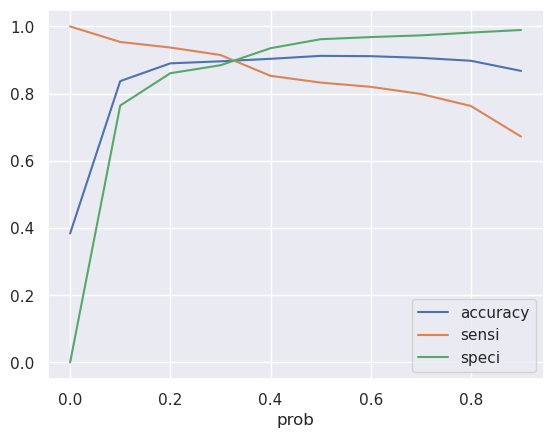

In [ ]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [ ]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.32 else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,final_predicted
0,0,0.100,295,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.089,1657,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0.999,4592,1,1,1,1,1,1,1,1,1,1,1,1
3,0,0.067,3558,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.104,629,0,1,1,0,0,0,0,0,0,0,0,0


In [ ]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.8979978354978355

In [ ]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[4053,  501],
       [ 253, 2585]])

In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

#### ROC Curve and Precision - Recall Curve

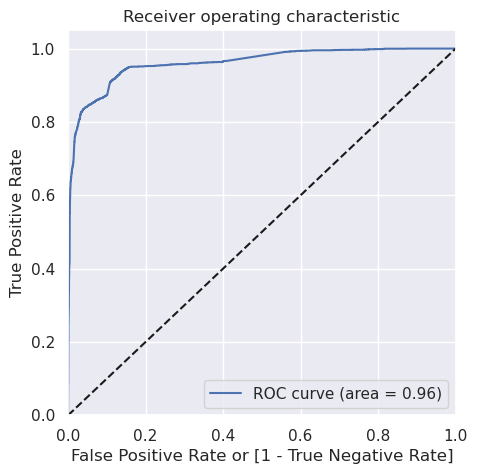

In [ ]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return None

fpr, tpr, thresholds = roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conv_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)

In [ ]:
precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.9318092234923138

0.8329809725158562

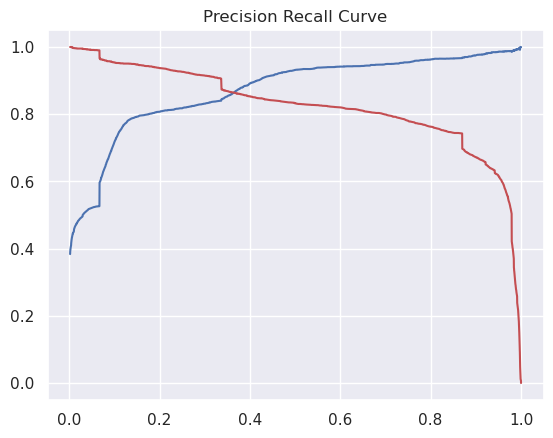

In [ ]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)
plt.plot(thresholds, p[:-1], "b")
plt.plot(thresholds, r[:-1], "r")
plt.title('Precision Recall Curve')
plt.show();

In [ ]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.37 else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,final_predicted
0,0,0.100,295,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.089,1657,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0.999,4592,1,1,1,1,1,1,1,1,1,1,1,1
3,0,0.067,3558,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.104,629,0,1,1,0,0,0,0,0,0,0,0,0


In [ ]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.8977272727272727

In [ ]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[4189,  365],
       [ 391, 2447]])

In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

###  ----------------------------------------------------------------------

### Predictions on the test set

##### Custom Functions for Test

In [ ]:
def logreg_test_pred_fn(fX_test, fy_test, fcol, fcutoff, fres):
    fX_test_sm = sm.add_constant(fX_test[fcol])
    fy_test_pred = fres.predict(fX_test_sm)
    fy_test_pred = fy_test_pred.values.reshape(-1)
    fy_test_pred_final = pd.DataFrame({'Converted':fy_test.values, 'Conv_Prob':fy_test_pred})
    fy_test_pred_final['ID'] = fy_test.index
    fy_test_pred_final['predicted'] = fy_test_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_test_pred,fy_test_pred_final

def logreg_test_metrics_fn(fy_test_pred_final):
    fconfusion = confusion_matrix(fy_test_pred_final.Converted, fy_test_pred_final.predicted )
    faccuracy = accuracy_score(fy_test_pred_final.Converted, fy_test_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_test_VIF_score_fn(fX_test, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_test[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_test[fcol].values, i) for i in 
                   range(fX_test[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

#### Model Validation on Test Data

In [ ]:
X_test[to_scale] = scaler.transform(X_test[to_scale])
X_test[col].head()

,ttime_on_site,last_activity_SMS Sent,lead_source_Welingak Website,tags_Already a student,tags_Closed by Horizzon,tags_Interested in full time MBA,tags_Interested in other courses,tags_Lost to EINS,tags_Not doing further education,tags_Ringing,tags_Will revert after reading the email,tags_invalid number,tags_switched off
2212,0.484,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
3034,0.549,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
4492,0.087,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5063,0.108,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
7645,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [ ]:
cutoff = 0.37
res, y_test_pred, y_test_pred_final = logreg_test_pred_fn(X_test, y_test, col, cutoff, res)
confusion, accuracy = logreg_test_metrics_fn(y_test_pred_final)
vif = logreg_test_VIF_score_fn(X_test, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_test_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_test_pred_final

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7378
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1685.3
Date:                Sun, 20 Oct 2024   Deviance:                       3370.5
Time:                        17:48:21   Pearson chi2:                 7.94e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5835
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -2.6332      0.080    -32.844      0.000      -2.790      -2.476
ttime_on_site                                3.2969      0.186     17.757      0.000       2.933       3.661
last_activity_SMS Sent                       1.9540      0.095     20.490      0.000       1.767       2.141
lead_source_Welingak Website                 5.4150      0.727      7.452      0.000       3.991       6.839
tags_Already a student                      -3.5004      0.714     -4.905      0.000      -4.899      -2.102
tags_Closed by Horizzon                      6.7526      0.715      9.446      0.000       5.352       8.154
tags_Interested  in full time MBA           -2.3946      0.747     -3.205      0.001      -3.859      -0.930
tags_Interested in other courses            -1.9275      0.312     -6.178      0.000      -2.539      -1.316
tags_Lost to EINS                            5.0964      0.517      9.848      0.000       4.082       6.111
tags_Not doing further education            -3.3026      1.013     -3.262      0.001      -5.287      -1.318
tags_Ringing                                -2.8049      0.207    -13.583      0.000      -3.210      -2.400
tags_Will revert after reading the email     4.5314      0.150     30.205      0.000       4.237       4.825
tags_invalid number                         -3.4164      1.062     -3.215      0.001      -5.499      -1.334
tags_switched off                           -3.2871      0.520     -6.325      0.000      -4.306      -2.269
============================================================================================================
"""


VIF Score:


,Features,VIF
0,ttime_on_site,1.640
10,tags_Will revert after reading the email,1.520
1,last_activity_SMS Sent,1.470
9,tags_Ringing,1.150
4,tags_Closed by Horizzon,1.080
2,lead_source_Welingak Website,1.040
6,tags_Interested in other courses,1.030
7,tags_Lost to EINS,1.030
12,tags_switched off,1.030
3,tags_Already a student,1.010


In [ ]:
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Confusion Matrix:


array([[1050,   75],
       [ 100,  623]])


Accuracy Score: 0.9053030303030303



In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

## Approach - 03 - Accuracy Score:

In [ ]:
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Accuracy Score: 0.9053030303030303



## ------------------------------------------------------

In [ ]:
# logreg = LogisticRegression()
# res = logreg.fit(X_train[col],y_train)

# scores = cross_val_score(res, X_train[col], y_train, cv=5, scoring='accuracy')
# np.sqrt(np.abs(scores))
# scores = cross_val_score(res, X_test[col], y_test, cv=5, scoring='accuracy')
# np.sqrt(np.abs(scores))

array([0.95927908, 0.95539463, 0.95181615, 0.95819237, 0.95110505])

array([0.95860259, 0.96282243, 0.95577901, 0.95707323, 0.95423745])